In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from dateutil import rrule
from datetime import date
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox, skew
from matplotlib import font_manager as fm
import os
import joblib
import hashlib
import csv
from dotenv import load_dotenv
load_dotenv()

products_with_boxcox = []


### removes data older than 4 months-----------------------------------------------------------------------------------------------
base_dir = Path(os.getenv("BASE_DIRECTORY"))
file_path = base_dir / "data/commodities/commodities_price_data.csv"
# csv_file = "commodities_price_data.csv"  # Update with your file path
save_dir = base_dir / "ml_models/commodities_saved_models"
filename = base_dir / "ml_models/commodities_saved_models/commodities_parameters.csv"
allYearsFilename = base_dir / "data/commodities/commodities_price_data-all_years.csv"
os.makedirs(save_dir, exist_ok=True)
data = pd.read_csv(file_path, encoding='utf-8', parse_dates=['Date'], date_format='%d/%m/%Y')
print(data.head())
products = data['Item Name'].unique()
print(products)

# Get current date and calculate the cutoff date (4 months ago)
current_date = datetime.today()
cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

today_date = datetime.now().strftime("%d/%m/%Y")

# Filter data to keep only the last 4 months
filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]

# Save the cleaned data back to CSV
filtered_data.to_csv(file_path, encoding='utf-8', index=False)

print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")

logs = []
###------------------------------------------------------------------------------------------------------------------------------

#function to get product parameters from csv
def get_product_parameters(filename, product_name):
    result = []
    
    # Open the CSV file
    with open(filename, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)  # Using DictReader to work with column headers
        for row in reader:
            if product_name in row['Item Name']:  # Check if product_name matches
                result.append({
                    'Date': row['Date'],
                    'Item Name': row['Item Name'],
                    'p': row['p'],
                    'd': row['d'],
                    'q': row['q']
                })
    
    return result


#function to update arima model parameters
def update_product_parameters(csv_file, today_date, product_name, p, d, q):
    # Read the existing CSV into a list of rows
    rows = []
    header = []
    
    # Open the CSV to read its current data
    if os.path.exists(csv_file):
        with open(csv_file, mode='r', newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            # Read the header and the rest of the rows
            header = next(reader)  # The first row is the header
            rows = list(reader)  # The rest of the rows are the data
    else:
        # If the file doesn't exist, we initialize an empty list for rows
        rows = []
    
    # Flag to check if the product is found
    product_found = False
    
    # Iterate through the rows and update the (p, d, q) values if the product is found
    for i, row in enumerate(rows):
        if row[1] == product_name:  # Assuming the 'Item Name' is in the second column (index 1)
            rows[i] = [today_date, product_name, p, d, q]  # Update the row with new values
            product_found = True
            message = f"Updated {product_name} with new (p, d, q): ({p}, {d}, {q})"
            # print(message)
            logs.append(message)
            break
    
    # If the product was not found, append it as a new entry
    if not product_found:
        rows.append([today_date, product_name, p, d, q])  # Add a new row for the product
        message = f"Added new item {product_name} with (p, d, q): ({p}, {d}, {q})"
        # print(message)
        logs.append(message)
    
    # Write the updated data back to the CSV
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write the header first
        writer.writerow(header)
        # Write all the rows (updated or new)
        writer.writerows(rows)



###Saving updated ARIMA models---------------------------------------------------------------------------------------------------

# Step 1: Stationarity Check
def check_stationarity(series, size):
    if len(series) == size:
        return True
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("The series is stationary (no further differencing needed).")
        return True
    else:
        print("The series is not stationary (differencing is required).")
        return False

# Function to count significant lags
def count_significant_spikes(values, confint):
    # The significant lags are those outside the confidence interval
    significant_lags = np.where(np.abs(values) > confint[:, 1])[0]
    return len(significant_lags), significant_lags

# Function to generate a safe file name
def safe_filename(product_name):
    return hashlib.md5(product_name.encode('utf-8')).hexdigest()





###updating the csv with current data---------------------------------------------------------------------------------------------

def write_to_csv(data, filename):
    # Define the field names for the CSV file
    # fieldnames = ['Serial Number', 'Date', 'Item Name', 'Low Price', 'Average Price', 'High Price']
    
    # Write data to CSV file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        # writer.writerow(fieldnames)
        
        # Write data rows
        for _, row_data in enumerate(data):
            date = row_data[0]
            item_name = row_data[2]
            low_price = row_data[3]
            avg_price = row_data[5]
            high_price = row_data[4]
            writer.writerow([date, item_name, low_price, avg_price, high_price])
            
            
def getData(driver, csv_file_name, webpage_path, date_path, submit_button_path, table_path):
    
    # add_field_names_price(csv_file_name)
    
    #iterate over all the dates    
    try:
        # Open the webpage
        driver.get(webpage_path)
            
        # Find the date input element
        date_input = driver.find_element(By.XPATH, date_path)

        # Clear any existing text in the date input field
        date_input.clear()
          
        # Enter the desired date
        date_input.send_keys(current_date.strftime('%d-%m-%Y'))  # Example date, replace with your desired date

        # Find and click the button to get data for the specified date
        submit_button = driver.find_element(By.XPATH, submit_button_path)
        submit_button.click()
         
        time.sleep(3) #to load data

        #Extract the table data
        table = driver.find_element(By.XPATH, table_path)
        # print(table)
        data = []

        # Iterate over each row in the table
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find all cells (td) in the row
            cells = row.find_elements(By.TAG_NAME, "td")
                
            # Ensure that there are cells in the row
            if cells:
                # Extract text from each cell and append to the data list
                row_data = [current_date.strftime('%d-%m-%Y')] + [cell.text.strip() for cell in cells]
                data.append(row_data)

        # Print the extracted data for debugging
        # for row in data:
        #     print(row)
        write_to_csv(data, csv_file_name)
        write_to_csv(data, allYearsFilename)
        time.sleep(2)
        # return data
            
    except Exception as e:
        print(e)
        pass


def main():
    # Initialize Chrome WebDriver
    driver = webdriver.Chrome()

    # commodities_data_table = 
    getData(driver, file_path, os.getenv("COMMODITIES_WEBPAGE_PATH"), 
                                             os.getenv("COMMODITIES_DATE_PATH"),
                                             os.getenv("COMMODITIES_SUBMIT_BUTTON_PATH"),
                                             os.getenv("COMMODITIES_TABLE_PATH"))
    
    time.sleep(5)
    
    # Close the WebDriver
    driver.quit()
    
    
    
    ###Updating models------------------------------------------------------------------------------------------------------------
    
    for product in products:
    
        product_name = product 
        product_data = data[data['Item Name'] == product_name]
        size_product_data = product_data.shape[0]
        print(product_name, "size: ", size_product_data)
        
        if((size_product_data//2)-1 <= 0):
            continue
        
        # Check if any data exists for the selected product
        if product_data.empty:
            print(f"No data found for the product: {product_name}")

        else:
            # Extract the 'Average Price' column for the selected product
            price_data = product_data['Average Price']
            # price_data.index = pd.to_datetime(price_data.index, format='%d-%m-%Y')
            # Get the last date in the dataset
            # latest_date = price_data.index.max()
            #print(latest_date)

            # Calculate the start date for the last 3 months
            # three_months_ago = latest_date - pd.DateOffset(months=3)
            #print(three_months_ago)

            # Filter the data for plotting
            # filtered_data = price_data[price_data.index >= three_months_ago]
            #print(filtered_data)


            # Plot the raw price data for the selected commodity
            # plt.figure(figsize=(12, 6))
            # plt.plot(price_data.index, price_data, label=f'{commodity_name} Prices', marker='o', linestyle='-')
            # plt.title(f'Price Trend for {commodity_name}')
            # plt.xlabel('Date')
            # plt.ylabel('Average Price')
            # plt.xticks(rotation=90)
            # plt.legend()
            # plt.grid()
            # plt.tight_layout()
            # plt.show()
            
        variance_ratio = price_data.std() / price_data.mean()
        skewness = skew(price_data)

        if variance_ratio > 0.1 and skewness > 0.5:
            apply_boxcox = True
            products_with_boxcox.append(product_name)
        else:
            apply_boxcox = False
        
        
        print(apply_boxcox)
        # Step 2: Differencing (if necessary)
        print(f"Checking stationarity for the raw price data of {product_name}:")
        d = 0
        price_diff = price_data
        
        try:
            if apply_boxcox:
                price_diff, lam = boxcox(price_diff)
                price_diff = pd.Series(price_diff)
        
            while True:
                if check_stationarity(price_diff, (size_product_data//2)+1):
                    # price_diff = price_data
                    print(f"Data is stationary with d={d}.")
                    break
                else:
                    price_diff = price_diff.diff().dropna()
                    d += 1
        
        # if check_stationarity(price_data):
        #   price_diff = price_data
        # else:
        #   price_diff = price_data.diff().dropna()  # Apply differencing to make the series stationary

            print("\nChecking stationarity for the differenced data:")
            check_stationarity(price_diff, (size_product_data//2)+1)
        
        except Exception as e:
            print(f"Stationarity cannot be applicable for {product_name}")
        # print(d)

        # filtered_price_diff = price_diff[price_diff.index >= three_months_ago]  # For differenced data

        # Plot the differenced data
        # plt.figure(figsize=(12, 6))
        # plt.plot(price_diff, label='Differenced Data', marker='o', linestyle='-')
        # plt.title('Differenced Data')
        # plt.xlabel('Date')
        # plt.ylabel('Price Difference')
        # plt.xticks(rotation=90)
        # plt.legend()
        # plt.grid()
        # plt.show()
        
        
        # Step 3: Plot ACF and PACF

        acf_values, acf_confint = acf(price_diff, alpha=0.05)
        pacf_values, pacf_confint = pacf(price_diff, alpha=0.05)


        # Count significant spikes for ACF (q)
        q, significant_acf_lags = count_significant_spikes(acf_values, acf_confint)

        # Count significant spikes for PACF (p)
        p, significant_pacf_lags = count_significant_spikes(pacf_values, pacf_confint)

        print(f"Significant spikes in ACF (q): {q} at lags {significant_acf_lags}")
        print(f"Significant spikes in PACF (p): {p} at lags {significant_pacf_lags}")

        # ACF and PACF Plots
        try:
            plt.figure(figsize=(12, 6))
            plot_acf(price_diff, lags=(size_product_data//2)-1, title="Autocorrelation Function (ACF)")
            plt.show()

            plt.figure(figsize=(12, 6))
            plot_pacf(price_diff, lags=(size_product_data//2)-1, title="Partial Autocorrelation Function (PACF)")
            plt.show()
        
        except Exception as e:
            print(f"Can't plot the acf/pacf plots for {product_name} due to {e}")

        # Explanation:
        # - ACF (Autocorrelation Function): Measures the correlation between a series and its lagged values.
        # - PACF (Partial Autocorrelation Function): Measures the correlation between a series and its lagged values,
        #   removing the influence of intermediate lags.
        # - Use these plots to decide on p (AR term) and q (MA term).
        
        if p > 5:
            p = min(5, q)
        if q > 5: 
            q = min(5, p)
        if d > 3:
            d = 1

        fit_successful = False

        while not fit_successful and q >= 0:
            try:
                print(f"\nFitting ARIMA model with order ({p}, {d}, {q})...")
                model = ARIMA(price_data, order=(p, d, q))
                model_fit = model.fit()
                fit_successful = True  
                print("ARIMA model fitted successfully!")
                
            except np.linalg.LinAlgError as err:
                print(f"Error encountered: {err}")
                if q > 0: 
                    q -= 1
                    print(f"Reducing q to {q} and trying again...")
                else:
                    print("Unable to fit model after reducing q multiple times. Exiting loop.")
                    break  
        
        
        # Step 5: Analyze Model Summary
        print("\nARIMA Model Summary:")
        print(model_fit.summary())
        
        
        product_parameters = get_product_parameters(filename, product_name)
        
        for item in product_parameters:
            p = item['p']
            d = item['d']
            q = item['q']
            
        update_product_parameters(filename, today_date, product_name, p, d, q)
        
        # with open(filename, mode='a', newline='', encoding='utf-8') as file:
        #     writer = csv.writer(file)
            
        #     # Write header row
        #     # writer.writerow(fieldnames)
        
        #     writer.writerow([today_date, product_name, p, d, q])
        
        
        try:
            # Assume model_fit is the fitted ARIMA model for this product
            hashed_name = safe_filename(product)
            model_filename = os.path.join(save_dir, f"arima_model_{hashed_name}.pkl")
            joblib.dump(model_fit, model_filename)
            print(f"Model for {product} saved as {model_filename}")
        except Exception as e:
            print(f"Error saving model for {product}: {e}")


if __name__ == "__main__":
    main()


# Storing models on Spaces

         Date     Item Name  Low Price  Average Price  High Price
0  09-12-2024  કપાસ બી. ટી.       1241           1441        1481
1  09-12-2024     ઘઉં લોકવન        550            594         612
2  09-12-2024     ઘઉં ટુકડા        580            656         736
3  09-12-2024    મગફળી જીણી        731           1081        1126
4  09-12-2024   સિંગ ફાડીયા        941           1181        1271
['કપાસ બી. ટી.' 'ઘઉં લોકવન' 'ઘઉં ટુકડા' 'મગફળી જીણી' 'સિંગ ફાડીયા'
 'એરંડા / એરંડી' 'જીરૂ' 'વરીયાળી' 'ધાણા' 'લસણ સુકું' 'ડુંગળી લાલ' 'અડદ'
 'તુવેર' 'રાજગરો' 'રાય' 'મેથી' 'કાંગ' 'મરચા' 'ગુવાર બી' 'મગફળી જાડી'
 'સફેદ ચણા' 'તલ - તલી' 'ધાણી' 'ડુંગળી સફેદ' 'બાજરો' 'જુવાર' 'મકાઇ' 'મગ'
 'ચણા' 'વાલ' 'ચોળા / ચોળી' 'સોયાબીન' 'ગોગળી' 'મઠ' 'સુવાદાણા' 'ઇસબગુલ'
 'તલ કાળા' 'સુરજમુખી' 'વટાણા' 'ક્લંજી' 'રાયડો' 'અજમાં' 'કળથી'
 'મરચા સૂકા પટ્ટો' 'અરીઠા' 'સિંગદાણા જાડા' 'તલ લાલ' 'નવા ધાણા'
 'રજકાનું બી' 'નવી ધાણી' 'નવું લસણ' 'નવું જીરૂ' 'વાલ પાપડી' 'કારીજીરી'
 'નવા ચણા' 'ઘઉં નવા' 'મરચા સૂકા ઘોલર']
Data older than 10-

<Figure size 1200x600 with 0 Axes>

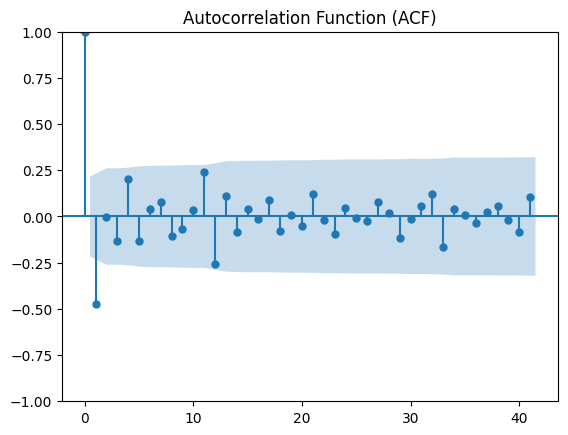

<Figure size 1200x600 with 0 Axes>

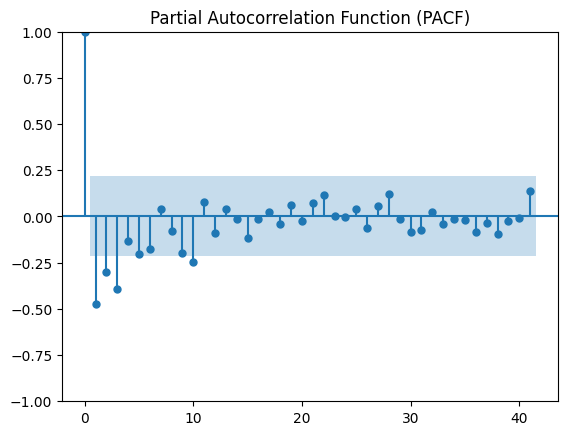


Fitting ARIMA model with order (2, 2, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   84
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -361.372
Date:                Wed, 09 Apr 2025   AIC                            732.743
Time:                        16:24:24   BIC                            744.777
Sample:                             0   HQIC                           737.574
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0491      0.083    -12.616      0.000      -1.212      -0.886
ar.L2         -0.1044      0.11

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for કપાસ બી. ટી. uploaded to Spaces at ml_models/commodities_saved_models/arima_model_bc5d04b4f2d950f2417a01a7667c612f.pkl
ઘઉં લોકવન size:  80
False
Checking stationarity for the raw price data of ઘઉં લોકવન:

ADF Test Results:
ADF Statistic: 0.2692
p-value: 0.9759
Critical Value 1%: -3.5171
Critical Value 5%: -2.8994
Critical Value 10%: -2.5870
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -10.3808
p-value: 0.0000
Critical Value 1%: -3.5171
Critical Value 5%: -2.8994
Critical Value 10%: -2.5870
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -10.3808
p-value: 0.0000
Critical Value 1%: -3.5171
Critical Value 5%: -2.8994
Critical Value 10%: -2.5870
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [1]
Significant spikes in PACF (p): 4 at lags [ 1  3  8 16]


<Figure size 1200x600 with 0 Axes>

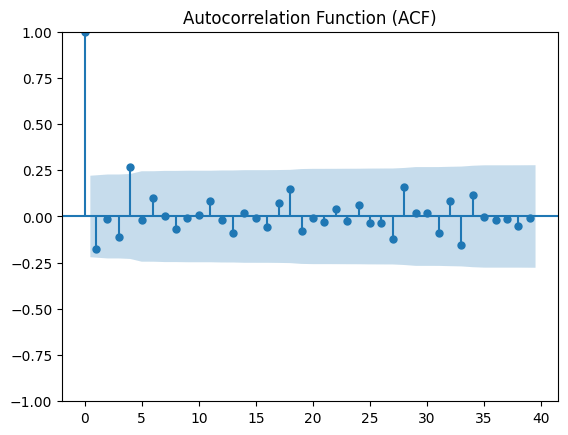

<Figure size 1200x600 with 0 Axes>

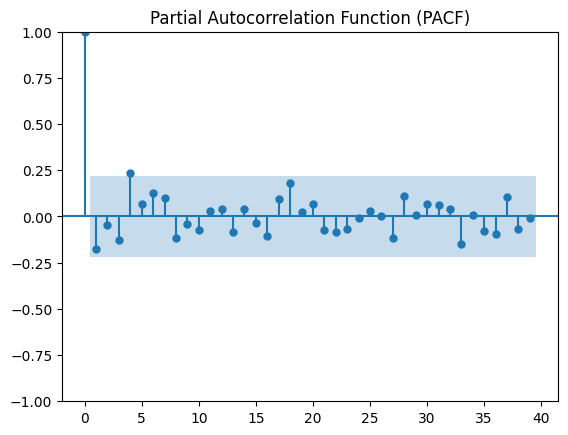


Fitting ARIMA model with order (4, 1, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   80
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -293.656
Date:                Wed, 09 Apr 2025   AIC                            599.312
Time:                        16:24:29   BIC                            613.529
Sample:                             0   HQIC                           605.008
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3323      0.390      0.853      0.394      -0.432       1.096
ar.L2          0.0480      0.134      0.358      0.720      -0.215       0.3

<Figure size 1200x600 with 0 Axes>

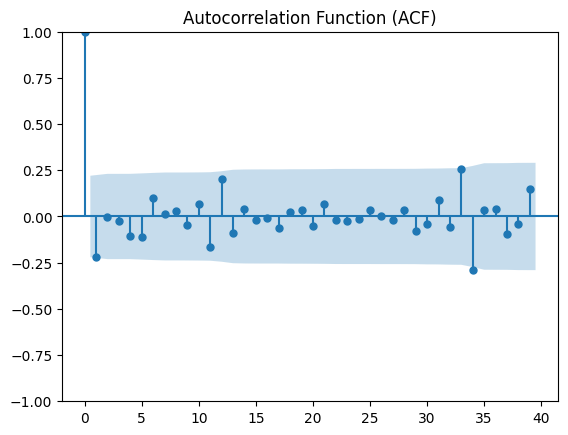

<Figure size 1200x600 with 0 Axes>

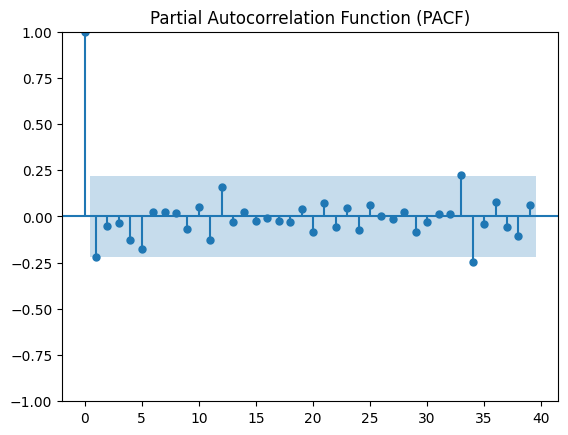


Fitting ARIMA model with order (4, 1, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   80
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -340.639
Date:                Wed, 09 Apr 2025   AIC                            695.278
Time:                        16:24:32   BIC                            711.864
Sample:                             0   HQIC                           701.923
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4697      0.413      1.136      0.256      -0.340       1.280
ar.L2         -0.5144      0.33

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ઘઉં ટુકડા uploaded to Spaces at ml_models/commodities_saved_models/arima_model_8ceef4d416fd107ab6c25f46c19ae5da.pkl
મગફળી જીણી size:  83
False
Checking stationarity for the raw price data of મગફળી જીણી:

ADF Test Results:
ADF Statistic: -1.9406
p-value: 0.3132
Critical Value 1%: -3.5160
Critical Value 5%: -2.8989
Critical Value 10%: -2.5867
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -8.5340
p-value: 0.0000
Critical Value 1%: -3.5160
Critical Value 5%: -2.8989
Critical Value 10%: -2.5867
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -8.5340
p-value: 0.0000
Critical Value 1%: -3.5160
Critical Value 5%: -2.8989
Critical Value 10%: -2.5867
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [1]
Significant spikes in PACF (p): 12 at lags [ 1  2  3  4  6  7 10 12 1

<Figure size 1200x600 with 0 Axes>

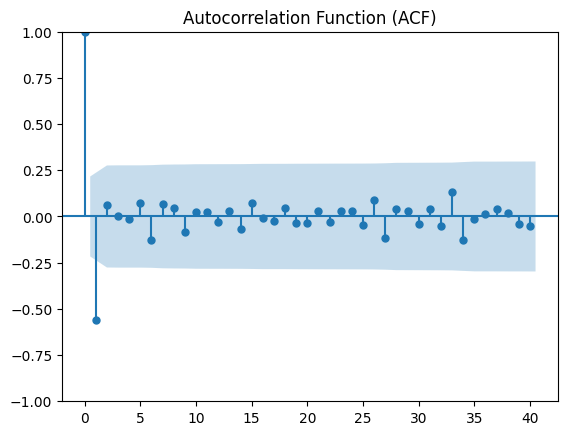

<Figure size 1200x600 with 0 Axes>

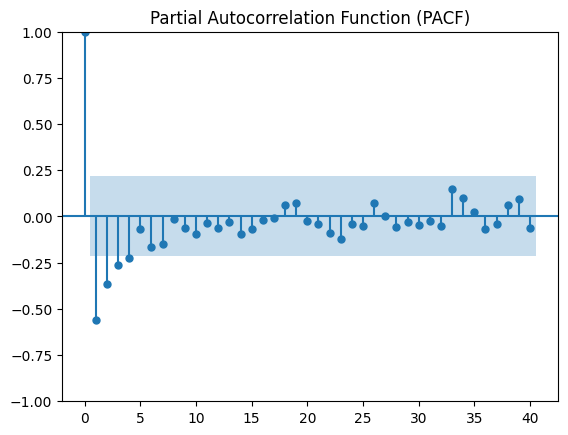


Fitting ARIMA model with order (1, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -340.293
Date:                Wed, 09 Apr 2025   AIC                            686.586
Time:                        16:24:35   BIC                            693.806
Sample:                             0   HQIC                           689.485
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1690      0.139     -1.215      0.224      -0.442       0.104
ma.L1         -0.7800      0.12

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for મગફળી જીણી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_76918a89b8bd994063b1e687c029250c.pkl
સિંગ ફાડીયા size:  86
False
Checking stationarity for the raw price data of સિંગ ફાડીયા:

ADF Test Results:
ADF Statistic: -1.2683
p-value: 0.6435
Critical Value 1%: -3.5233
Critical Value 5%: -2.9020
Critical Value 10%: -2.5884
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -2.3376
p-value: 0.1601
Critical Value 1%: -3.5233
Critical Value 5%: -2.9020
Critical Value 10%: -2.5884
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -7.1959
p-value: 0.0000
Critical Value 1%: -3.5233
Critical Value 5%: -2.9020
Critical Value 10%: -2.5884
The series is stationary (no further differencing needed).
Data is stationary with d=2.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -7.1959
p-value: 0.0000
Critical Value 1%: -3.5233
Critical Value 5%: -2.9020
C

<Figure size 1200x600 with 0 Axes>

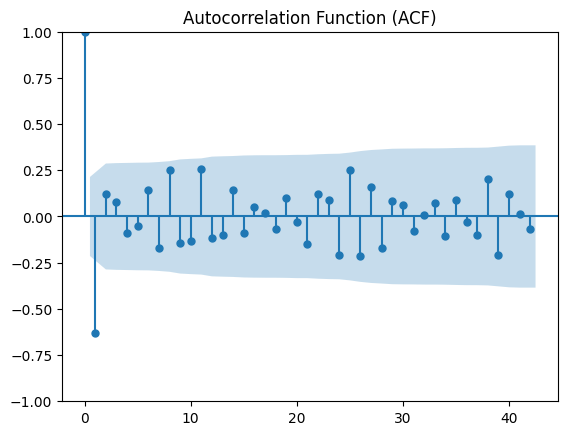

<Figure size 1200x600 with 0 Axes>

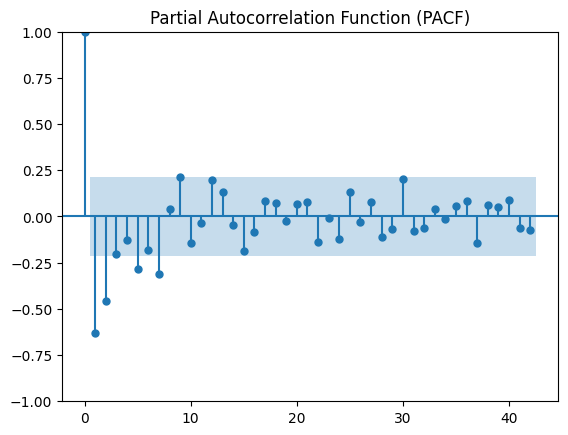


Fitting ARIMA model with order (2, 2, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   86
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -434.239
Date:                Wed, 09 Apr 2025   AIC                            878.478
Time:                        16:24:38   BIC                            890.632
Sample:                             0   HQIC                           883.364
                                 - 86                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4004      0.263     -5.321      0.000      -1.916      -0.885
ar.L2         -0.4200      0.13

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for સિંગ ફાડીયા uploaded to Spaces at ml_models/commodities_saved_models/arima_model_5293fdc8f807b512b8f514b79dd54f95.pkl
એરંડા / એરંડી size:  86
False
Checking stationarity for the raw price data of એરંડા / એરંડી:

ADF Test Results:
ADF Statistic: -1.6202
p-value: 0.4726
Critical Value 1%: -3.5107
Critical Value 5%: -2.8966
Critical Value 10%: -2.5855
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -8.3648
p-value: 0.0000
Critical Value 1%: -3.5117
Critical Value 5%: -2.8970
Critical Value 10%: -2.5857
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -8.3648
p-value: 0.0000
Critical Value 1%: -3.5117
Critical Value 5%: -2.8970
Critical Value 10%: -2.5857
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 4 at lags [ 1  6 16 18]
Significant spikes in PACF (p): 5 at lags [ 1  2  6

<Figure size 1200x600 with 0 Axes>

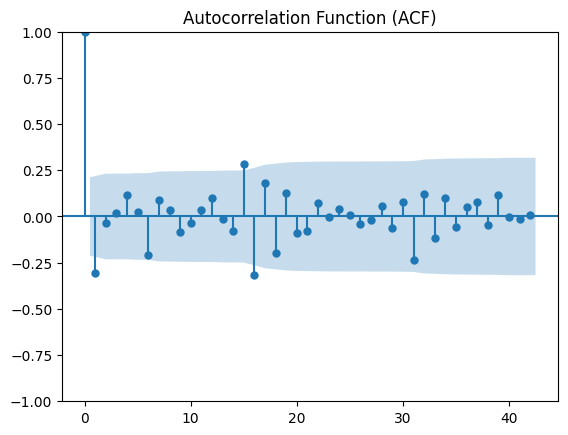

<Figure size 1200x600 with 0 Axes>

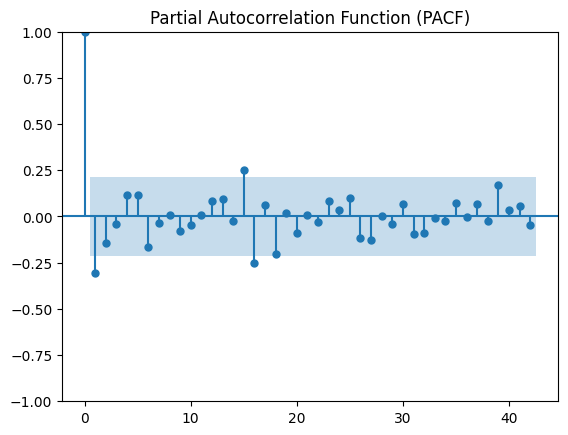


Fitting ARIMA model with order (5, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   86
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -335.097
Date:                Wed, 09 Apr 2025   AIC                            690.194
Time:                        16:24:45   BIC                            714.620
Sample:                             0   HQIC                           700.019
                                 - 86                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6535      0.201     -3.255      0.001      -1.047      -0.260
ar.L2         -0.2428      0.289     -0.840      0.401      -0.810       0.3

<Figure size 1200x600 with 0 Axes>

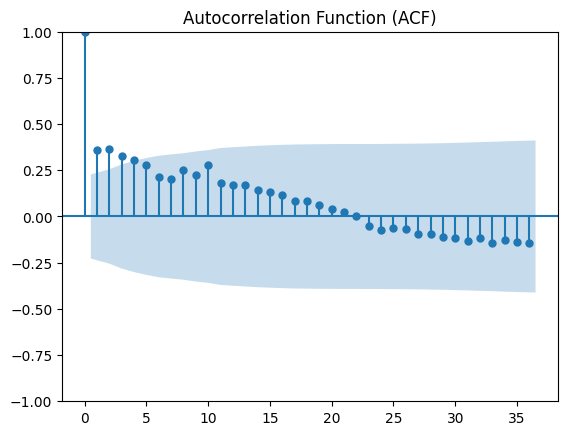

<Figure size 1200x600 with 0 Axes>

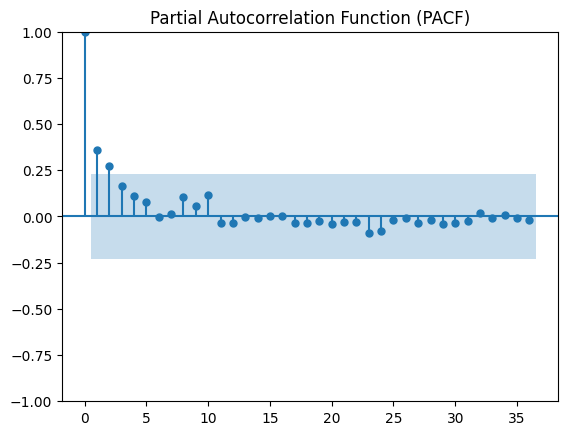


Fitting ARIMA model with order (0, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   74
Model:                          ARIMA   Log Likelihood                -565.957
Date:                Wed, 09 Apr 2025   AIC                           1135.914
Time:                        16:24:49   BIC                           1140.522
Sample:                             0   HQIC                          1137.752
                                 - 74                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4112.8244    114.849     35.811      0.000    3887.725    4337.923
sigma2      2.573e+05   1.87e+0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for જીરૂ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_705ea0772a9b99e73230d9c9741dad00.pkl
વરીયાળી size:  57
True
Checking stationarity for the raw price data of વરીયાળી:

ADF Test Results:
ADF Statistic: -2.8825
p-value: 0.0474
Critical Value 1%: -3.5553
Critical Value 5%: -2.9157
Critical Value 10%: -2.5957
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -2.8825
p-value: 0.0474
Critical Value 1%: -3.5553
Critical Value 5%: -2.9157
Critical Value 10%: -2.5957
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 2 at lags [ 8 12]
Significant spikes in PACF (p): 3 at lags [ 6 12 16]


<Figure size 1200x600 with 0 Axes>

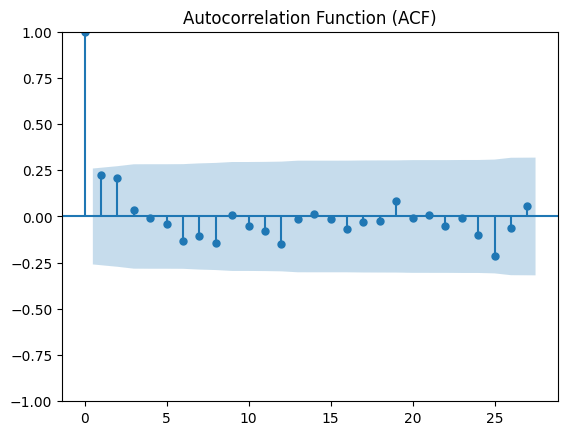

<Figure size 1200x600 with 0 Axes>

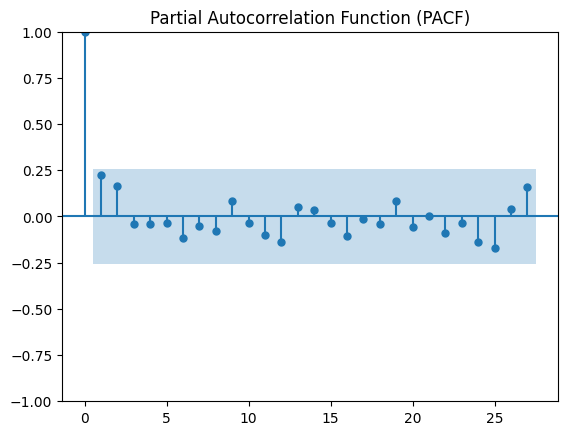


Fitting ARIMA model with order (3, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   57
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -403.788
Date:                Wed, 09 Apr 2025   AIC                            821.575
Time:                        16:24:51   BIC                            835.876
Sample:                             0   HQIC                           827.133
                                 - 57                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1305.6061    198.546      6.576      0.000     916.463    1694.749
ar.L1          1.3626      0.717      1.901      0.057      -0.042       2.7

<Figure size 1200x600 with 0 Axes>

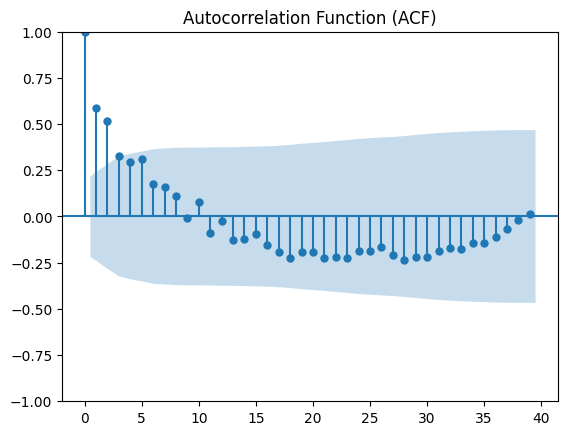

<Figure size 1200x600 with 0 Axes>

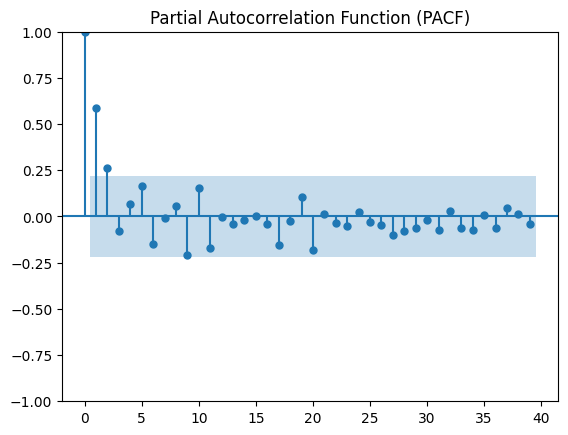


Fitting ARIMA model with order (4, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   81
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -416.302
Date:                Wed, 09 Apr 2025   AIC                            848.603
Time:                        16:24:55   BIC                            867.759
Sample:                             0   HQIC                           856.289
                                 - 81                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1474.8229     27.163     54.296      0.000    1421.585    1528.061
ar.L1         -0.7894      0.331     -2.382      0.017      -1.439      -0.1

<Figure size 1200x600 with 0 Axes>

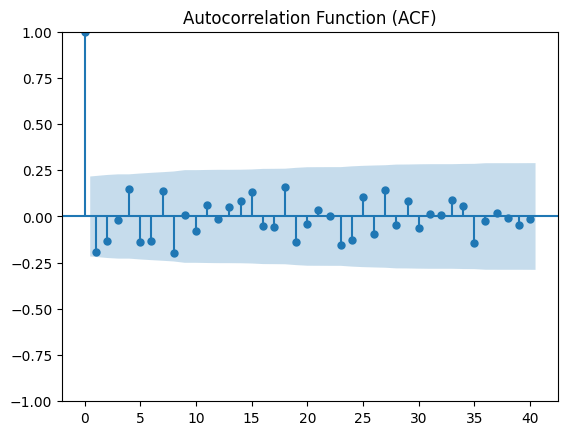

<Figure size 1200x600 with 0 Axes>

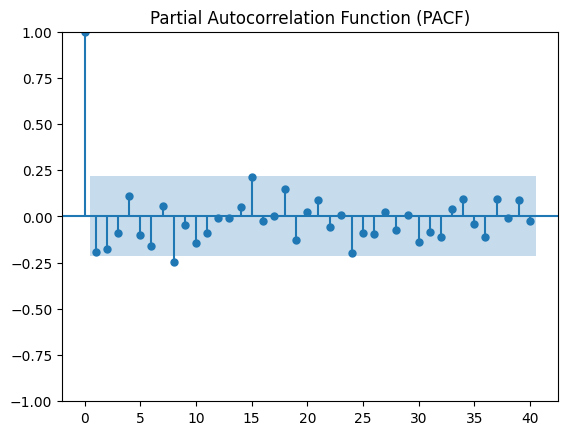


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -548.030
Date:                Wed, 09 Apr 2025   AIC                           1118.060
Time:                        16:24:59   BIC                           1144.533
Sample:                             0   HQIC                          1128.688
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0774      0.480     -0.161      0.872      -1.018       0.863
ar.L2         -0.8148      0.288     -2.825      0.005      -1.380      -0.2

<Figure size 1200x600 with 0 Axes>

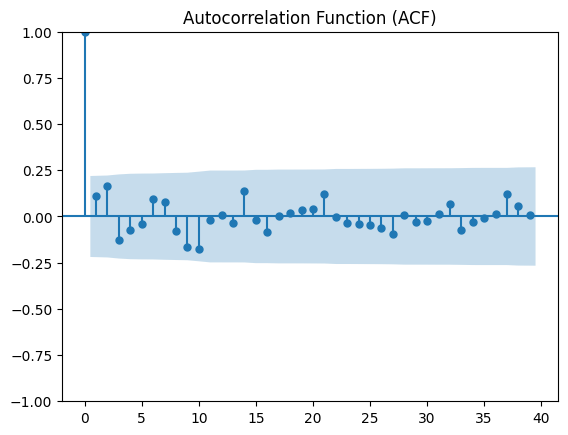

<Figure size 1200x600 with 0 Axes>

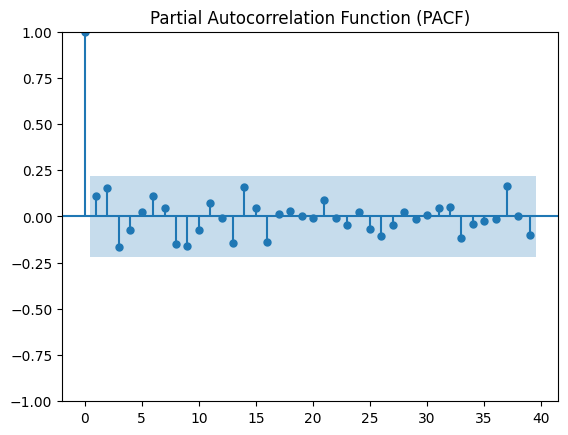


Fitting ARIMA model with order (5, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   81
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -398.329
Date:                Wed, 09 Apr 2025   AIC                            814.658
Time:                        16:25:03   BIC                            836.096
Sample:                             0   HQIC                           823.253
                                 - 81                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2822      0.369     -0.764      0.445      -1.006       0.442
ar.L2         -0.1086      0.313     -0.347      0.728      -0.722       0.5

<Figure size 1200x600 with 0 Axes>

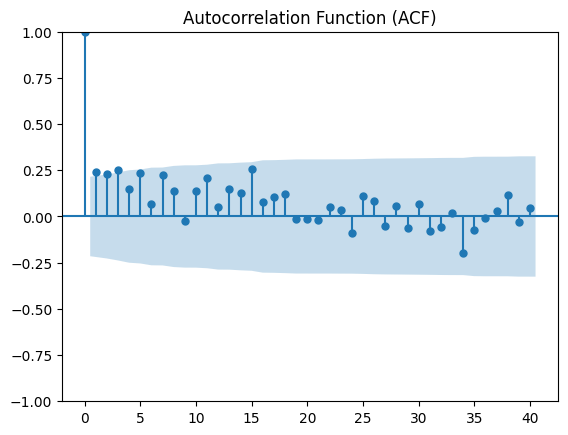

<Figure size 1200x600 with 0 Axes>

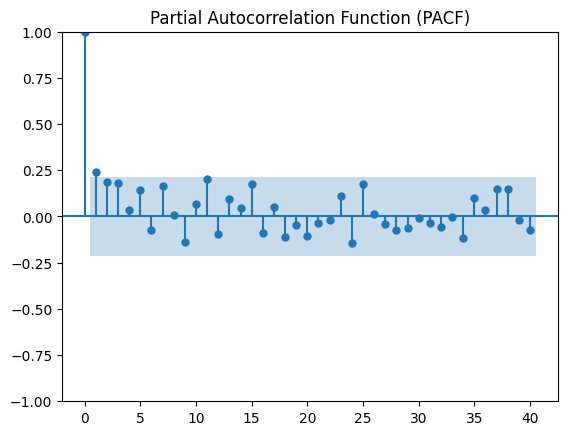


Fitting ARIMA model with order (4, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -495.575
Date:                Wed, 09 Apr 2025   AIC                           1003.150
Time:                        16:25:06   BIC                           1017.663
Sample:                             0   HQIC                          1008.981
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1497.3934     30.950     48.380      0.000    1436.732    1558.055
ar.L1          0.1545      0.133      1.158      0.247      -0.107       0.4

<Figure size 1200x600 with 0 Axes>

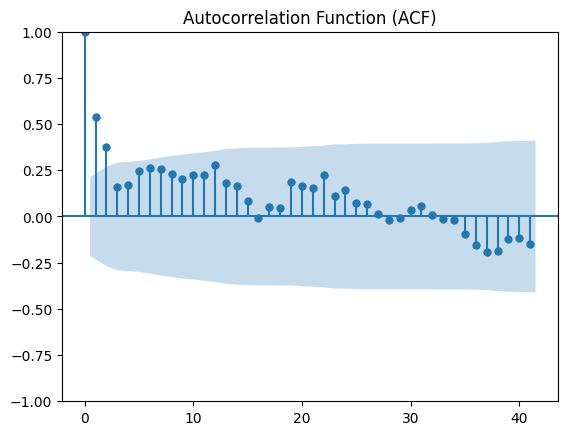

<Figure size 1200x600 with 0 Axes>

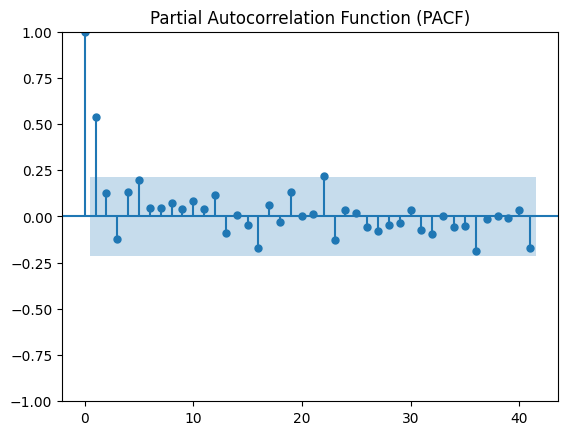


Fitting ARIMA model with order (2, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   84
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -518.137
Date:                Wed, 09 Apr 2025   AIC                           1044.274
Time:                        16:25:09   BIC                           1053.997
Sample:                             0   HQIC                          1048.182
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1457.1540     39.733     36.674      0.000    1379.279    1535.029
ar.L1          0.4625      0.06

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for તુવેર uploaded to Spaces at ml_models/commodities_saved_models/arima_model_2b0b6c6c9287c5c4ef5113cf987a1d9b.pkl
રાજગરો size:  12
True
Checking stationarity for the raw price data of રાજગરો:

ADF Test Results:
ADF Statistic: -2.4268
p-value: 0.1343
Critical Value 1%: -4.6652
Critical Value 5%: -3.3672
Critical Value 10%: -2.8030
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -4.0062
p-value: 0.0014
Critical Value 1%: -4.9387
Critical Value 5%: -3.4776
Critical Value 10%: -2.8439
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.0062
p-value: 0.0014
Critical Value 1%: -4.9387
Critical Value 5%: -3.4776
Critical Value 10%: -2.8439
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [1]
Significant spikes in PACF (p): 1 at lags [1]


<Figure size 1200x600 with 0 Axes>

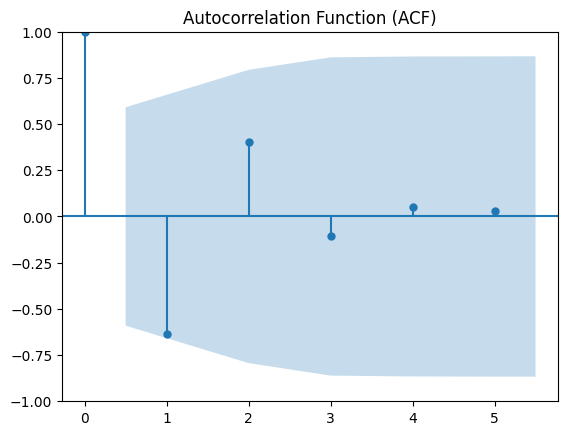

<Figure size 1200x600 with 0 Axes>

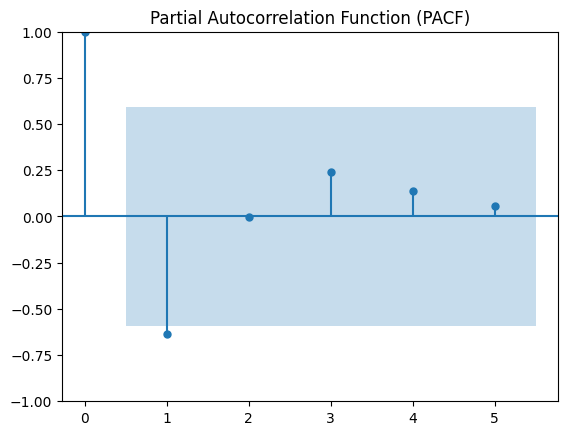


Fitting ARIMA model with order (1, 1, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -83.449
Date:                Wed, 09 Apr 2025   AIC                            172.897
Time:                        16:25:12   BIC                            174.091
Sample:                             0   HQIC                           172.145
                                 - 12                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.070    -14.255      0.000      -1.137      -0.862
ma.L1         -0.2521      1.053     -0.239      0.811      -2.317       1.8

<Figure size 1200x600 with 0 Axes>

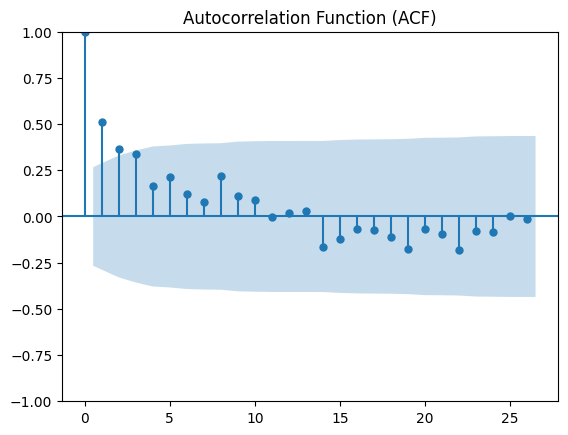

<Figure size 1200x600 with 0 Axes>

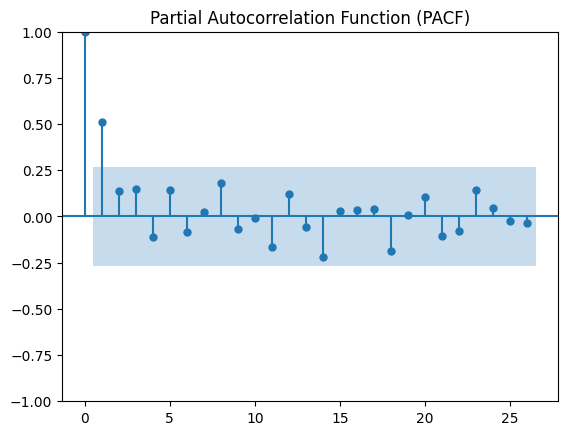


Fitting ARIMA model with order (2, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   54
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -315.083
Date:                Wed, 09 Apr 2025   AIC                            638.165
Time:                        16:25:14   BIC                            646.121
Sample:                             0   HQIC                           641.233
                                 - 54                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1065.4464     26.440     40.297      0.000    1013.626    1117.267
ar.L1          0.4347      0.16

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for રાય uploaded to Spaces at ml_models/commodities_saved_models/arima_model_af87db7c4e2153de48f7a2d1ab4dfeba.pkl
મેથી size:  82
False
Checking stationarity for the raw price data of મેથી:

ADF Test Results:
ADF Statistic: -3.6451
p-value: 0.0050
Critical Value 1%: -3.5149
Critical Value 5%: -2.8984
Critical Value 10%: -2.5864
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -3.6451
p-value: 0.0050
Critical Value 1%: -3.5149
Critical Value 5%: -2.8984
Critical Value 10%: -2.5864
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 4 at lags [13 14 15 18]
Significant spikes in PACF (p): 3 at lags [ 8 13 18]


<Figure size 1200x600 with 0 Axes>

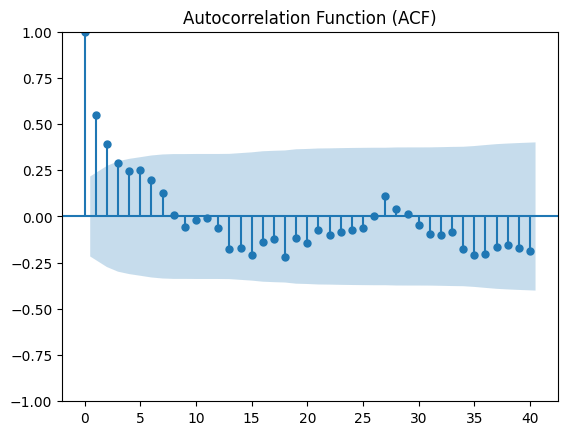

<Figure size 1200x600 with 0 Axes>

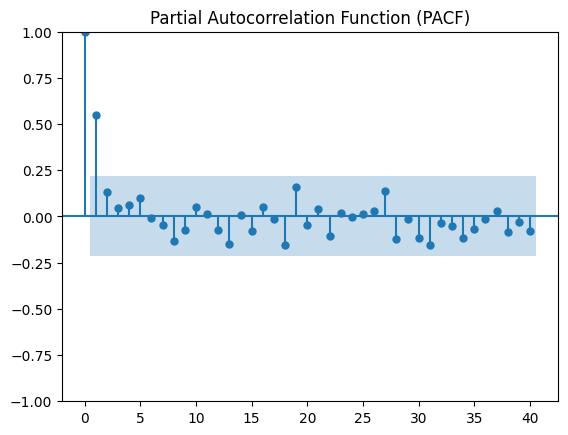


Fitting ARIMA model with order (3, 0, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(3, 0, 4)   Log Likelihood                -484.006
Date:                Wed, 09 Apr 2025   AIC                            986.012
Time:                        16:25:19   BIC                           1007.672
Sample:                             0   HQIC                           994.708
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        963.8174     34.308     28.093      0.000     896.575    1031.060
ar.L1          1.5956      0.155     10.275      0.000       1.291       1.9

<Figure size 1200x600 with 0 Axes>

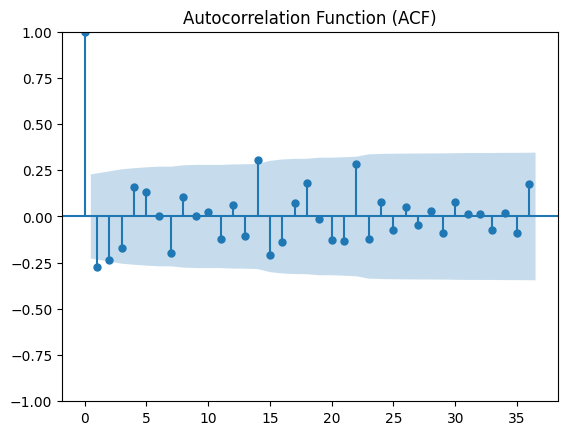

<Figure size 1200x600 with 0 Axes>

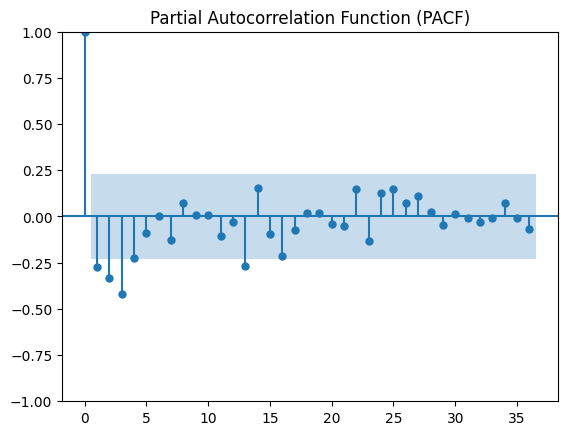


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   75
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -482.606
Date:                Wed, 09 Apr 2025   AIC                            987.211
Time:                        16:25:22   BIC                           1012.556
Sample:                             0   HQIC                           997.322
                                 - 75                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4035      0.530     -0.761      0.447      -1.443       0.636
ar.L2         -0.7890      0.452     -1.744      0.081      -1.676       0.0

<Figure size 1200x600 with 0 Axes>

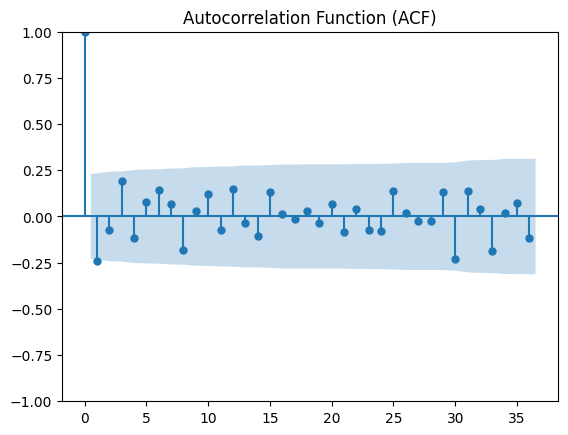

<Figure size 1200x600 with 0 Axes>

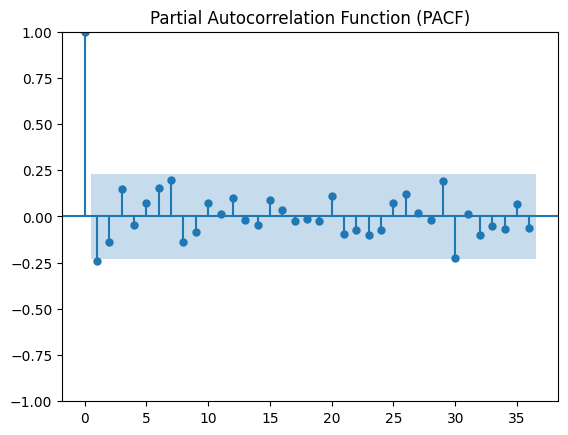


Fitting ARIMA model with order (3, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   74
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -422.542
Date:                Wed, 09 Apr 2025   AIC                            857.083
Time:                        16:25:29   BIC                            870.826
Sample:                             0   HQIC                           862.560
                                 - 74                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0689      0.408      0.169      0.866      -0.730       0.868
ar.L2          0.5047      0.367      1.376      0.169      -0.214       1.2

<Figure size 1200x600 with 0 Axes>

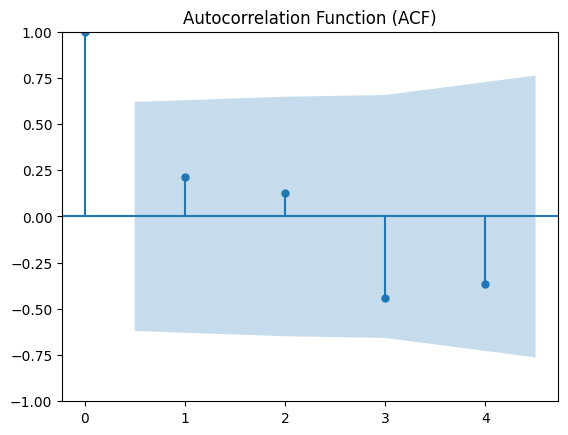

<Figure size 1200x600 with 0 Axes>

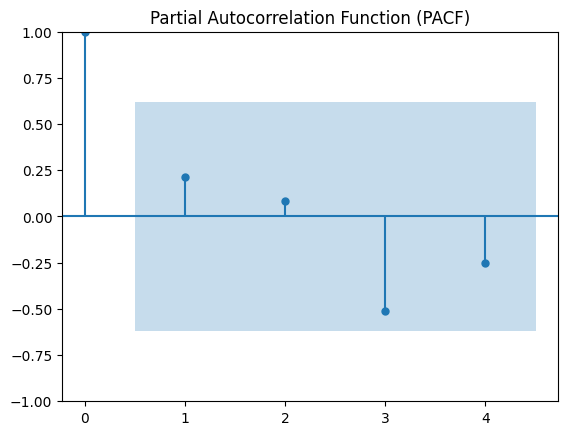


Fitting ARIMA model with order (2, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   10
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -61.347
Date:                Wed, 09 Apr 2025   AIC                            132.695
Time:                        16:25:32   BIC                            134.208
Sample:                             0   HQIC                           131.035
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        792.4739    144.507      5.484      0.000     509.245    1075.702
ar.L1         -0.3463      1.94

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for ગુવાર બી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_b3efe0dd5d26617ba59a43460887cc2e.pkl
મગફળી જાડી size:  83
False
Checking stationarity for the raw price data of મગફળી જાડી:

ADF Test Results:
ADF Statistic: -2.6931
p-value: 0.0752
Critical Value 1%: -3.5138
Critical Value 5%: -2.8979
Critical Value 10%: -2.5862
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -15.6164
p-value: 0.0000
Critical Value 1%: -3.5138
Critical Value 5%: -2.8979
Critical Value 10%: -2.5862
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -15.6164
p-value: 0.0000
Critical Value 1%: -3.5138
Critical Value 5%: -2.8979
Critical Value 10%: -2.5862
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [1]
Significant spikes in PACF (p): 11 at lags [ 1  2  3  4  6  7 12 14 

<Figure size 1200x600 with 0 Axes>

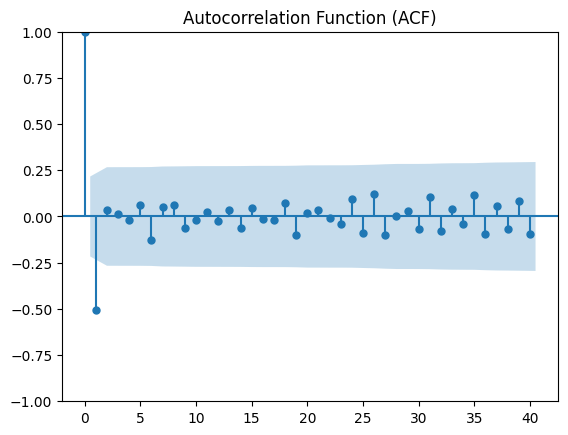

<Figure size 1200x600 with 0 Axes>

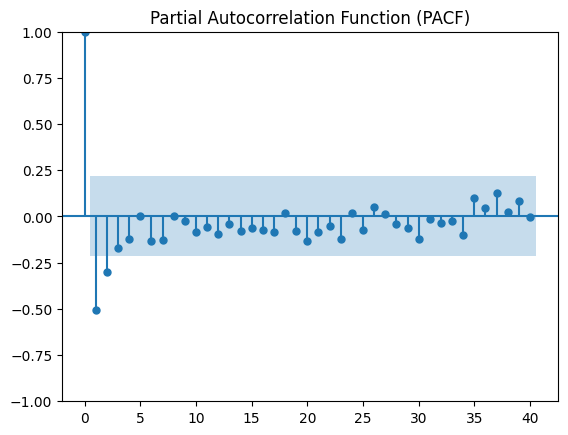


Fitting ARIMA model with order (1, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -336.828
Date:                Wed, 09 Apr 2025   AIC                            679.656
Time:                        16:25:34   BIC                            686.876
Sample:                             0   HQIC                           682.554
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1208      0.094     -1.290      0.197      -0.304       0.063
ma.L1         -0.6422      0.14

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for મગફળી જાડી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_63f9bef57ceb96566040d4fcf61cc68b.pkl
સફેદ ચણા size:  82
True
Checking stationarity for the raw price data of સફેદ ચણા:

ADF Test Results:
ADF Statistic: -2.4199
p-value: 0.1362
Critical Value 1%: -3.5149
Critical Value 5%: -2.8984
Critical Value 10%: -2.5864
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -7.5048
p-value: 0.0000
Critical Value 1%: -3.5171
Critical Value 5%: -2.8994
Critical Value 10%: -2.5870
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -7.5048
p-value: 0.0000
Critical Value 1%: -3.5171
Critical Value 5%: -2.8994
Critical Value 10%: -2.5870
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 3 at lags [ 1  9 19]
Significant spikes in PACF (p): 8 at lags [ 1  2  3  4  5  9 15 17

<Figure size 1200x600 with 0 Axes>

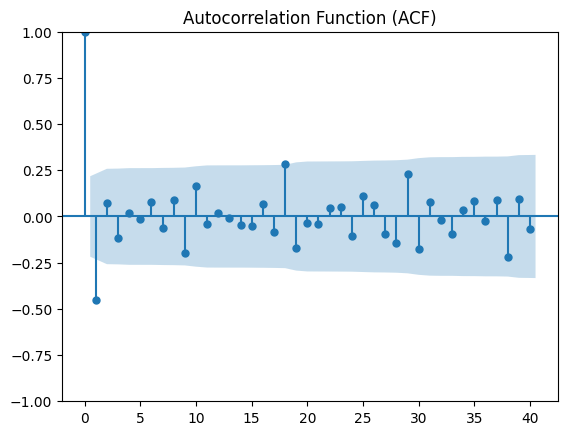

<Figure size 1200x600 with 0 Axes>

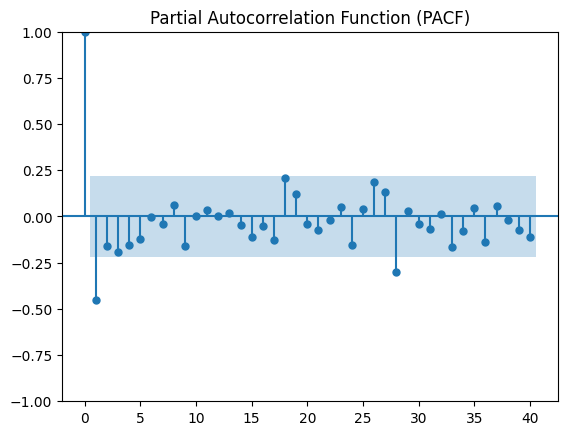


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -524.370
Date:                Wed, 09 Apr 2025   AIC                           1062.739
Time:                        16:25:37   BIC                           1079.500
Sample:                             0   HQIC                          1069.464
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7814     39.265     -0.020      0.984     -77.740      76.177
ar.L2          0.2276     21.482      0.011      0.992     -41.877      42.3

<Figure size 1200x600 with 0 Axes>

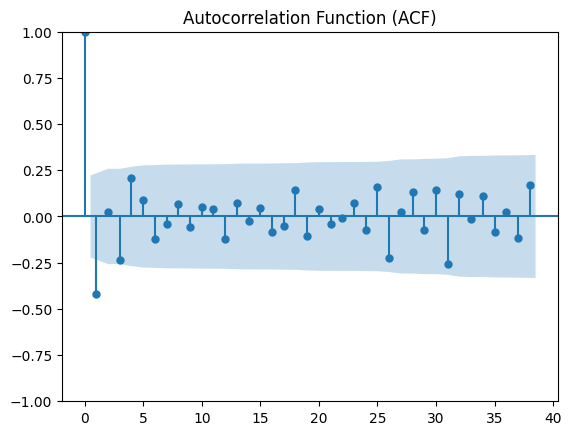

<Figure size 1200x600 with 0 Axes>

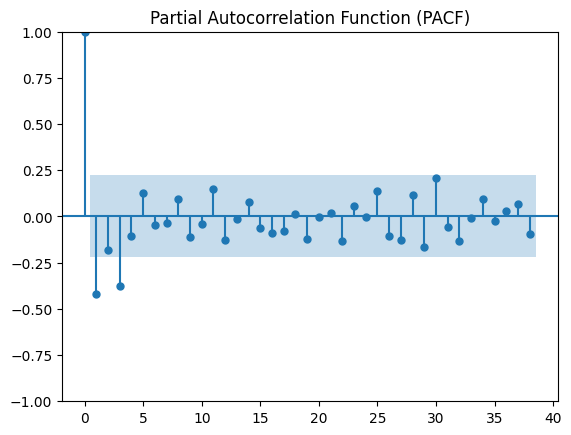


Fitting ARIMA model with order (2, 1, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   79
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -472.221
Date:                Wed, 09 Apr 2025   AIC                            954.443
Time:                        16:25:40   BIC                            966.226
Sample:                             0   HQIC                           959.160
                                 - 79                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6019      0.843     -0.714      0.475      -2.254       1.050
ar.L2          0.1387      0.18

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for તલ - તલી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_7e1ef0afc9707b6988035c60006378fd.pkl
ધાણી size:  81
False
Checking stationarity for the raw price data of ધાણી:

ADF Test Results:
ADF Statistic: -3.6380
p-value: 0.0051
Critical Value 1%: -3.5149
Critical Value 5%: -2.8984
Critical Value 10%: -2.5864
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -3.6380
p-value: 0.0051
Critical Value 1%: -3.5149
Critical Value 5%: -2.8984
Critical Value 10%: -2.5864
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 3 at lags [16 17 18]
Significant spikes in PACF (p): 5 at lags [ 7  8 11 16 17]


<Figure size 1200x600 with 0 Axes>

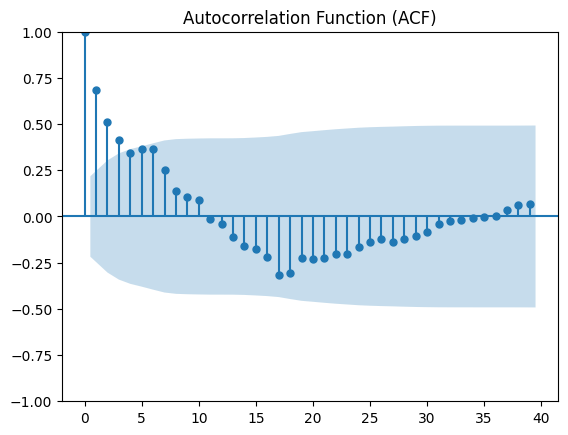

<Figure size 1200x600 with 0 Axes>

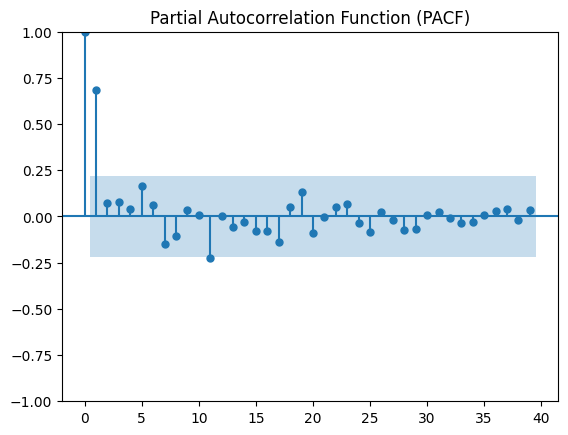


Fitting ARIMA model with order (5, 0, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   81
Model:                 ARIMA(5, 0, 3)   Log Likelihood                -469.540
Date:                Wed, 09 Apr 2025   AIC                            959.079
Time:                        16:25:44   BIC                            983.024
Sample:                             0   HQIC                           968.686
                                 - 81                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1524.3604     99.420     15.333      0.000    1329.501    1719.220
ar.L1          1.0516      1.761      0.597      0.550      -2.400       4.5

<Figure size 1200x600 with 0 Axes>

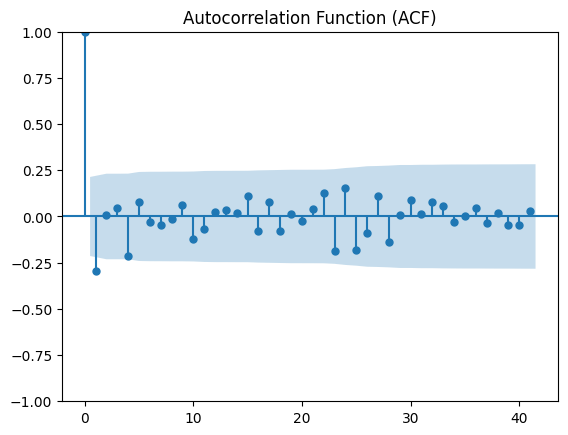

<Figure size 1200x600 with 0 Axes>

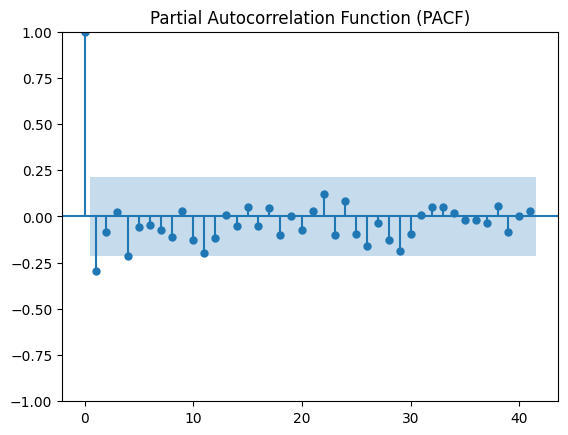


Fitting ARIMA model with order (2, 1, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   85
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -409.068
Date:                Wed, 09 Apr 2025   AIC                            828.135
Time:                        16:25:47   BIC                            840.289
Sample:                             0   HQIC                           833.021
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2968      0.341     -3.804      0.000      -1.965      -0.629
ar.L2         -0.5083      0.34

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ડુંગળી સફેદ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_4bf838b090a63a11778cd275bb2e65d3.pkl
બાજરો size:  72
False
Checking stationarity for the raw price data of બાજરો:

ADF Test Results:
ADF Statistic: -2.4463
p-value: 0.1291
Critical Value 1%: -3.5289
Critical Value 5%: -2.9044
Critical Value 10%: -2.5897
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -6.7579
p-value: 0.0000
Critical Value 1%: -3.5336
Critical Value 5%: -2.9064
Critical Value 10%: -2.5907
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -6.7579
p-value: 0.0000
Critical Value 1%: -3.5336
Critical Value 5%: -2.9064
Critical Value 10%: -2.5907
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 3 at lags [ 1  9 14]
Significant spikes in PACF (p): 7 at lags [ 1  2  4  5  6  9 15]


<Figure size 1200x600 with 0 Axes>

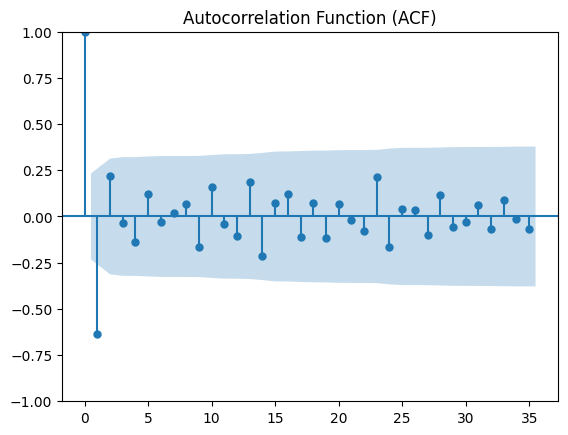

<Figure size 1200x600 with 0 Axes>

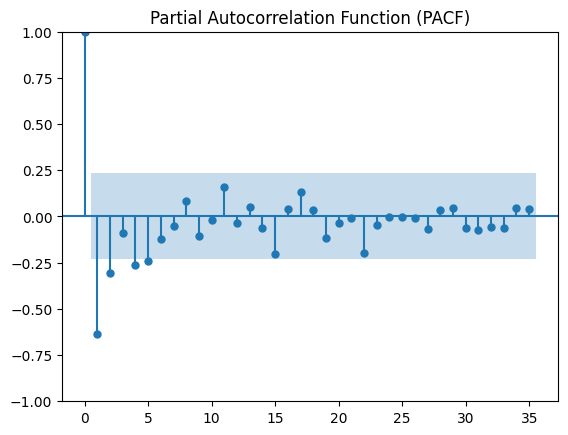


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   72
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -378.607
Date:                Wed, 09 Apr 2025   AIC                            771.213
Time:                        16:25:50   BIC                            787.052
Sample:                             0   HQIC                           777.512
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0437      0.123      0.355      0.723      -0.198       0.285
ar.L2         -0.7059      0.157     -4.499      0.000      -1.014      -0.3

<Figure size 1200x600 with 0 Axes>

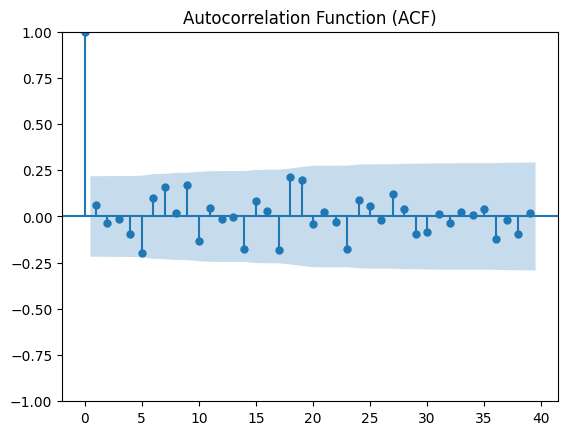

<Figure size 1200x600 with 0 Axes>

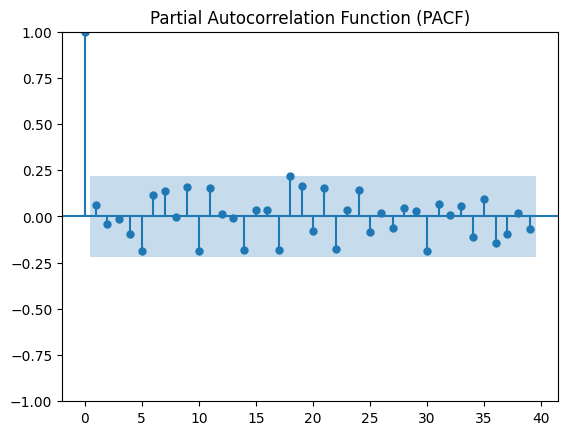


Fitting ARIMA model with order (4, 0, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   81
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -519.015
Date:                Wed, 09 Apr 2025   AIC                           1058.030
Time:                        16:25:53   BIC                           1081.975
Sample:                             0   HQIC                          1067.637
                                 - 81                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        755.3482     22.727     33.236      0.000     710.804     799.892
ar.L1          0.5584      0.216      2.583      0.010       0.135       0.9

<Figure size 1200x600 with 0 Axes>

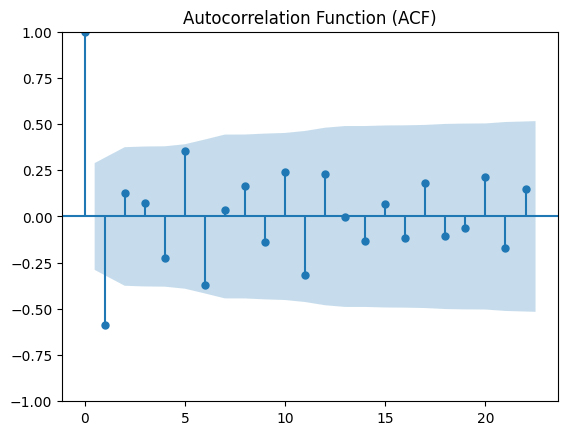

<Figure size 1200x600 with 0 Axes>

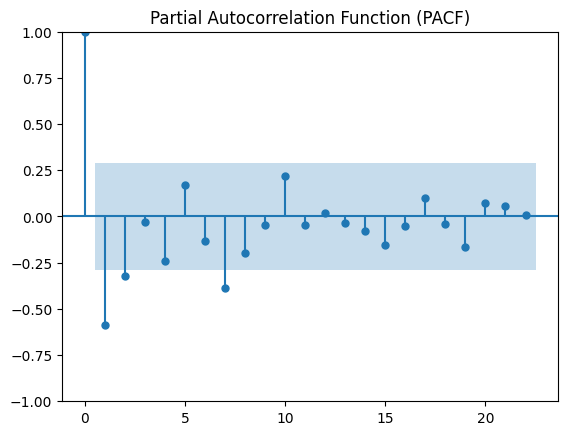


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   47
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -238.263
Date:                Wed, 09 Apr 2025   AIC                            494.527
Time:                        16:25:56   BIC                            510.985
Sample:                             0   HQIC                           500.692
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1081      0.199     -5.561      0.000      -1.499      -0.717
ar.L2         -1.0649      0.261     -4.086      0.000      -1.576      -0.5

<Figure size 1200x600 with 0 Axes>

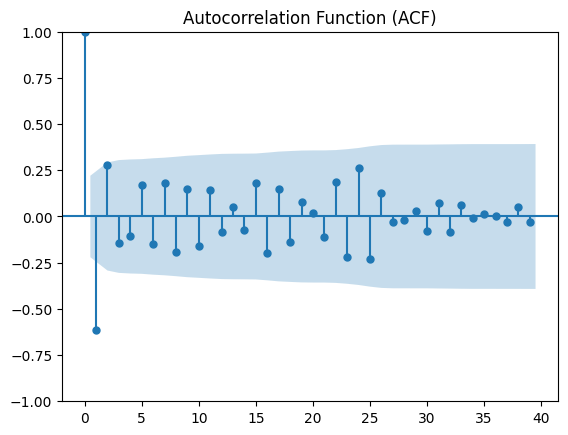

<Figure size 1200x600 with 0 Axes>

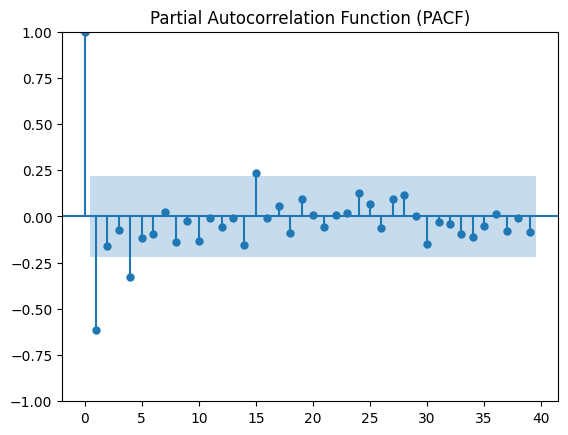


Fitting ARIMA model with order (3, 1, 3)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   80
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -489.517
Date:                Wed, 09 Apr 2025   AIC                            993.033
Time:                        16:25:59   BIC                           1009.619
Sample:                             0   HQIC                           999.678
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8115      0.128     -6.338      0.000      -1.063      -0.561
ar.L2         -0.8050      0.17

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for મગ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_0b6e645ac8664f4d0541742ab121ed52.pkl
ચણા size:  83
False
Checking stationarity for the raw price data of ચણા:

ADF Test Results:
ADF Statistic: -1.4051
p-value: 0.5798
Critical Value 1%: -3.5160
Critical Value 5%: -2.8989
Critical Value 10%: -2.5867
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -4.6727
p-value: 0.0001
Critical Value 1%: -3.5160
Critical Value 5%: -2.8989
Critical Value 10%: -2.5867
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.6727
p-value: 0.0001
Critical Value 1%: -3.5160
Critical Value 5%: -2.8989
Critical Value 10%: -2.5867
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 4 at lags [ 1  4  7 14]
Significant spikes in PACF (p): 6 at lags [ 1  2  8  9 14 18]


<Figure size 1200x600 with 0 Axes>

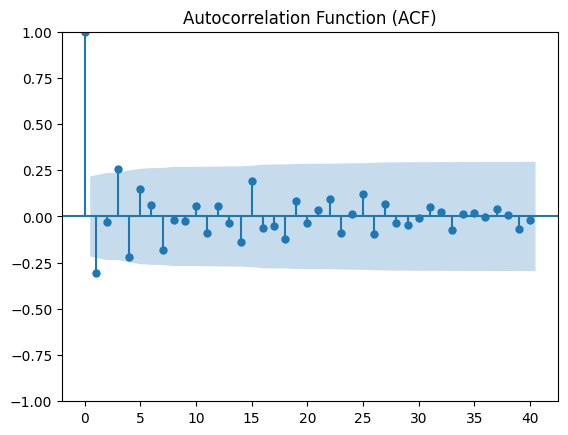

<Figure size 1200x600 with 0 Axes>

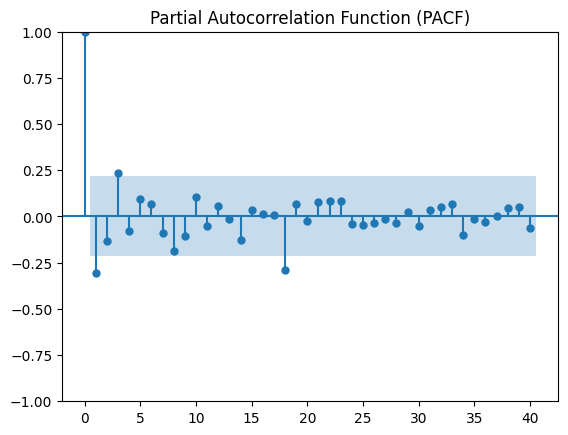


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -377.636
Date:                Wed, 09 Apr 2025   AIC                            773.273
Time:                        16:26:03   BIC                            794.933
Sample:                             0   HQIC                           781.969
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0057      0.355     -0.016      0.987      -0.702       0.691
ar.L2         -0.2506      0.332     -0.755      0.451      -0.901       0.4

<Figure size 1200x600 with 0 Axes>

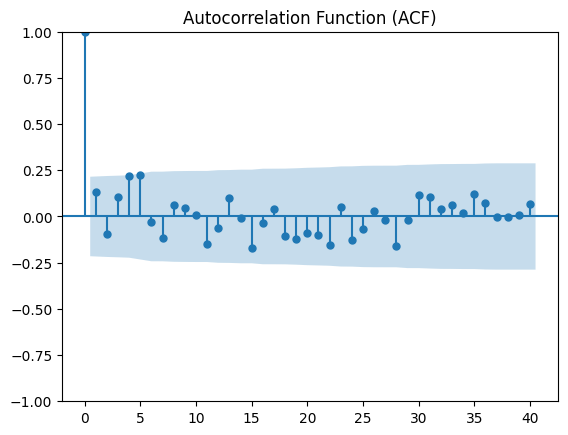

<Figure size 1200x600 with 0 Axes>

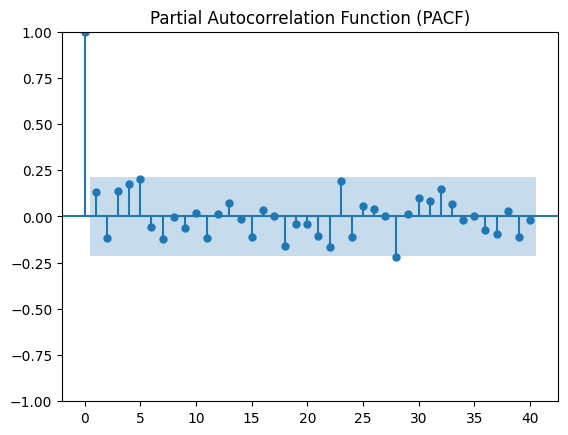


Fitting ARIMA model with order (5, 0, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -541.195
Date:                Wed, 09 Apr 2025   AIC                           1100.390
Time:                        16:26:06   BIC                           1122.159
Sample:                             0   HQIC                          1109.135
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1058.9274     40.360     26.237      0.000     979.823    1138.032
ar.L1          0.2060      0.55

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for વાલ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_582548504db8984a15acce3e49f95575.pkl
ચોળા / ચોળી size:  78
False
Checking stationarity for the raw price data of ચોળા / ચોળી:

ADF Test Results:
ADF Statistic: -8.6490
p-value: 0.0000
Critical Value 1%: -3.5183
Critical Value 5%: -2.8999
Critical Value 10%: -2.5872
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -8.6490
p-value: 0.0000
Critical Value 1%: -3.5183
Critical Value 5%: -2.8999
Critical Value 10%: -2.5872
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 2 at lags [ 5 16]
Significant spikes in PACF (p): 3 at lags [ 9 13 16]


<Figure size 1200x600 with 0 Axes>

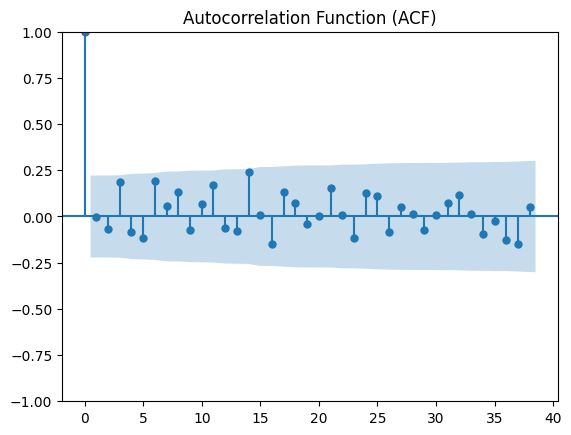

<Figure size 1200x600 with 0 Axes>

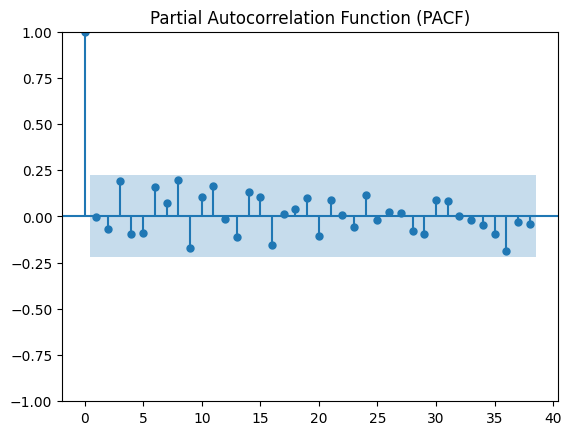


Fitting ARIMA model with order (3, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   78
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -580.395
Date:                Wed, 09 Apr 2025   AIC                           1174.790
Time:                        16:26:10   BIC                           1191.287
Sample:                             0   HQIC                          1181.394
                                 - 78                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1403.6254     71.754     19.562      0.000    1262.991    1544.260
ar.L1         -0.0899      0.150     -0.598      0.550      -0.384       0.2

<Figure size 1200x600 with 0 Axes>

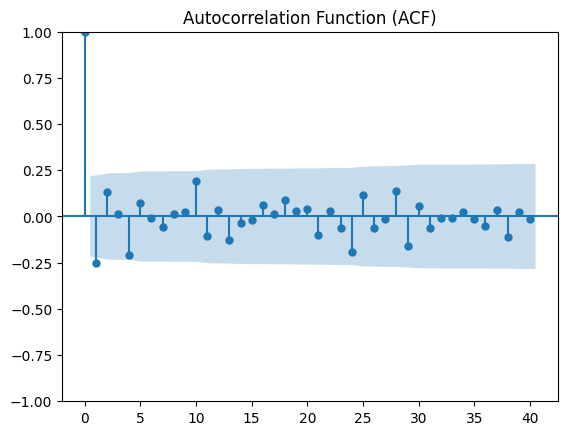

<Figure size 1200x600 with 0 Axes>

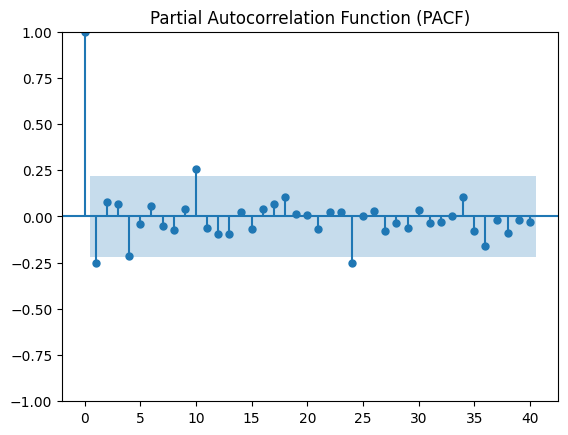


Fitting ARIMA model with order (4, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -310.279
Date:                Wed, 09 Apr 2025   AIC                            634.558
Time:                        16:26:13   BIC                            651.319
Sample:                             0   HQIC                           641.282
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2995      0.144     -2.077      0.038      -0.582      -0.017
ar.L2         -0.7323      0.177     -4.149      0.000      -1.078      -0.3

<Figure size 1200x600 with 0 Axes>

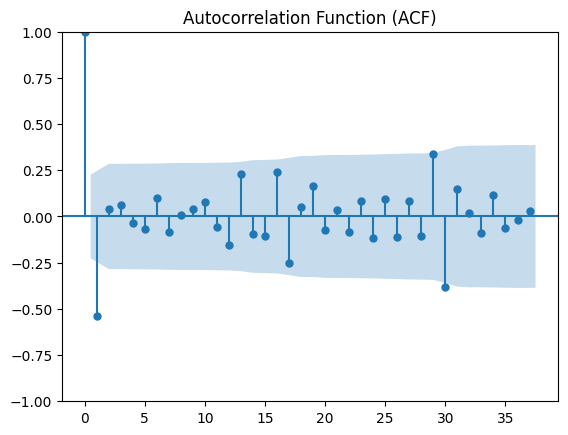

<Figure size 1200x600 with 0 Axes>

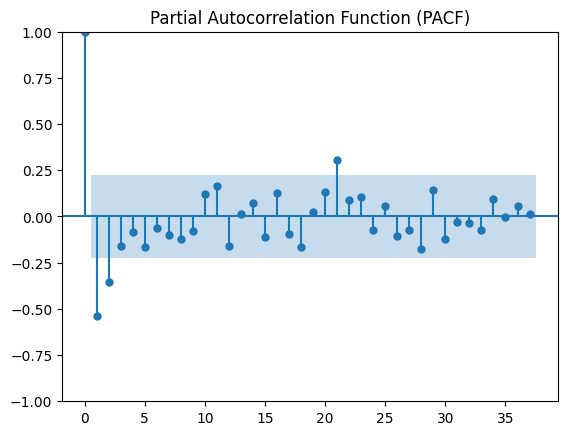


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   76
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -393.325
Date:                Wed, 09 Apr 2025   AIC                            800.650
Time:                        16:26:16   BIC                            816.872
Sample:                             0   HQIC                           807.127
                                 - 76                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5003      0.221     -2.264      0.024      -0.933      -0.067
ar.L2         -0.8409      0.274     -3.071      0.002      -1.377      -0.3

<Figure size 1200x600 with 0 Axes>

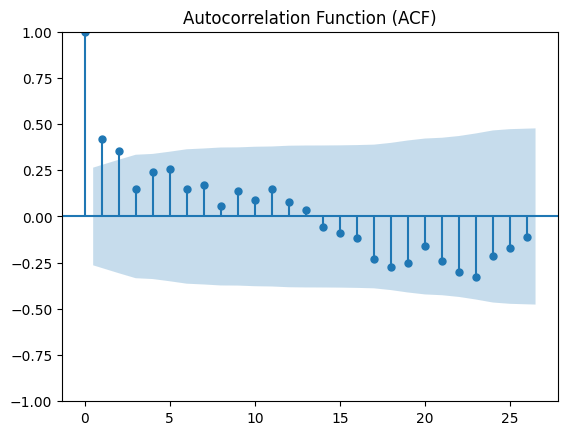

<Figure size 1200x600 with 0 Axes>

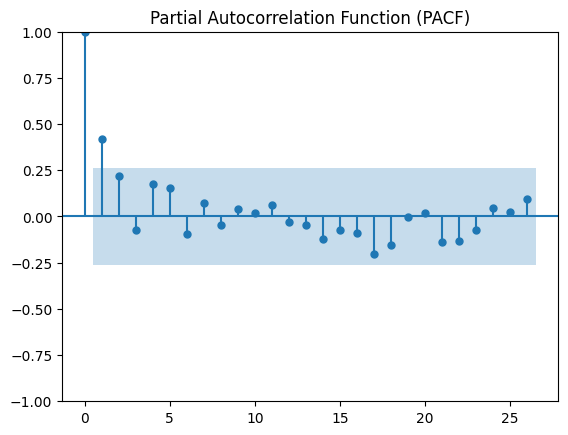


Fitting ARIMA model with order (3, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   55
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -366.506
Date:                Wed, 09 Apr 2025   AIC                            745.011
Time:                        16:26:19   BIC                            757.055
Sample:                             0   HQIC                           749.669
                                 - 55                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        868.7928     64.440     13.482      0.000     742.494     995.092
ar.L1          0.0304      1.53

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for મઠ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_618bfca119eb0a78e5b88f71d7050618.pkl
સુવાદાણા size:  8
False
Checking stationarity for the raw price data of સુવાદાણા:

ADF Test Results:
ADF Statistic: -51.7411
p-value: 0.0000
Critical Value 1%: -6.0451
Critical Value 5%: -3.9293
Critical Value 10%: -2.9868
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -51.7411
p-value: 0.0000
Critical Value 1%: -6.0451
Critical Value 5%: -3.9293
Critical Value 10%: -2.9868
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [3]
Significant spikes in PACF (p): 2 at lags [2 3]


<Figure size 1200x600 with 0 Axes>

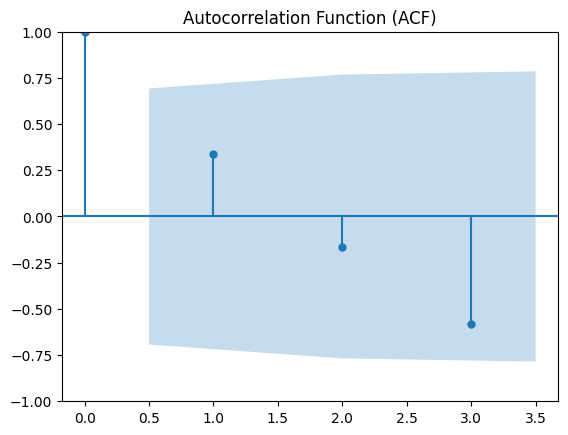

<Figure size 1200x600 with 0 Axes>

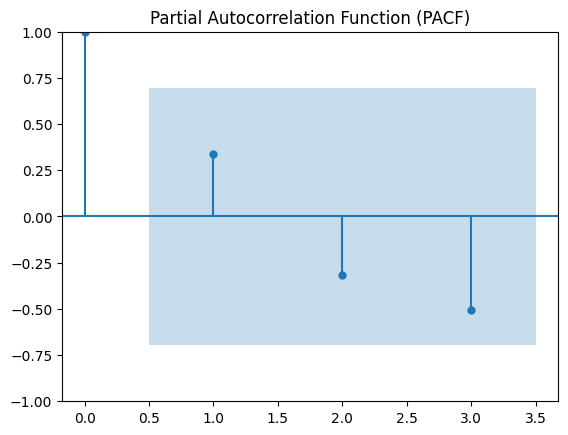


Fitting ARIMA model with order (2, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    8
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -43.398
Date:                Wed, 09 Apr 2025   AIC                             96.796
Time:                        16:26:22   BIC                             97.193
Sample:                             0   HQIC                            94.117
                                  - 8                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1210.5391     12.571     96.294      0.000    1185.900    1235.178
ar.L1          1.0362      0.39

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for સુવાદાણા uploaded to Spaces at ml_models/commodities_saved_models/arima_model_aa5a27e7fa2e0ddc4d6438cf6ce4afc4.pkl
ઇસબગુલ size:  25
False
Checking stationarity for the raw price data of ઇસબગુલ:

ADF Test Results:
ADF Statistic: -4.5464
p-value: 0.0002
Critical Value 1%: -3.7377
Critical Value 5%: -2.9922
Critical Value 10%: -2.6357
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.5464
p-value: 0.0002
Critical Value 1%: -3.7377
Critical Value 5%: -2.9922
Critical Value 10%: -2.6357
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 1 at lags [9]


<Figure size 1200x600 with 0 Axes>

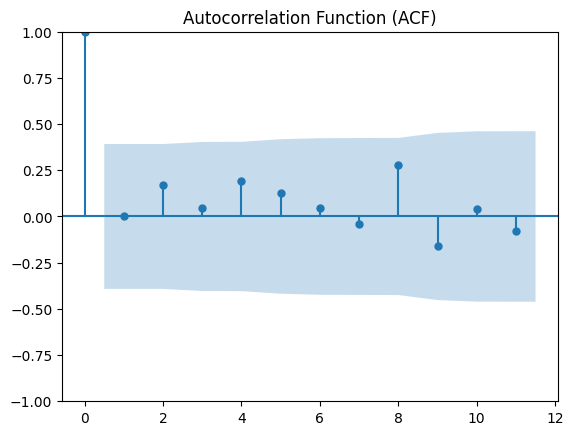

<Figure size 1200x600 with 0 Axes>

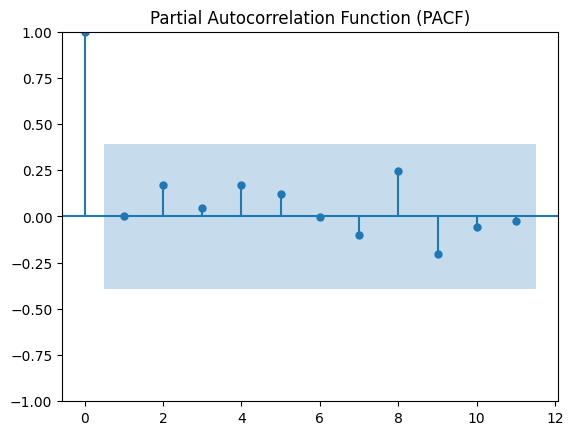


Fitting ARIMA model with order (1, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   25
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -180.788
Date:                Wed, 09 Apr 2025   AIC                            367.576
Time:                        16:26:23   BIC                            371.233
Sample:                             0   HQIC                           368.590
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1709.3518     71.238     23.995      0.000    1569.728    1848.976
ar.L1          0.0026      0.24

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ઇસબગુલ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_677c5bca1c7d6ace1388141bdfb15765.pkl
તલ કાળા size:  21
False
Checking stationarity for the raw price data of તલ કાળા:

ADF Test Results:
ADF Statistic: -3.5631
p-value: 0.0065
Critical Value 1%: -3.8092
Critical Value 5%: -3.0216
Critical Value 10%: -2.6507
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -3.5631
p-value: 0.0065
Critical Value 1%: -3.8092
Critical Value 5%: -3.0216
Critical Value 10%: -2.6507
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [12]
Significant spikes in PACF (p): 1 at lags [4]


<Figure size 1200x600 with 0 Axes>

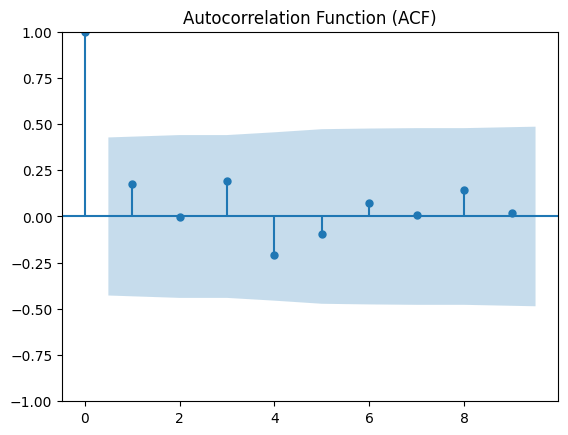

<Figure size 1200x600 with 0 Axes>

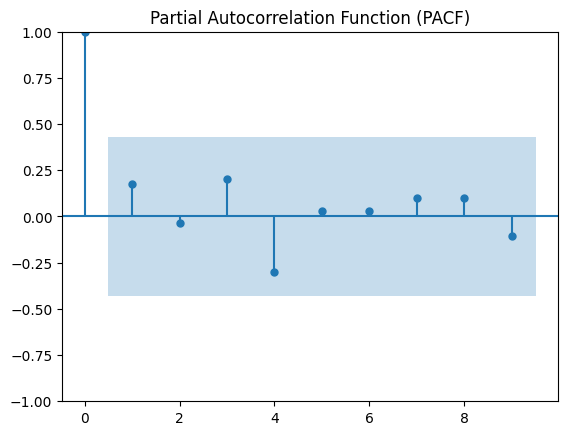


Fitting ARIMA model with order (1, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   21
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -162.126
Date:                Wed, 09 Apr 2025   AIC                            332.253
Time:                        16:26:26   BIC                            336.431
Sample:                             0   HQIC                           333.159
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4283.5229    188.710     22.699      0.000    3913.658    4653.388
ar.L1         -0.5010      0.773     -0.648      0.517      -2.015       1.0

<Figure size 1200x600 with 0 Axes>

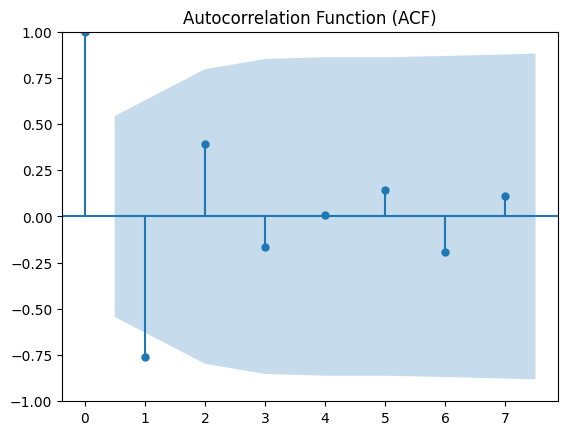

Can't plot the acf/pacf plots for સુરજમુખી due to Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 7 must be < 6.

Fitting ARIMA model with order (4, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   17
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -113.111
Date:                Wed, 09 Apr 2025   AIC                            238.222
Time:                        16:26:28   BIC                            242.858
Sample:                             0   HQIC                           238.459
                                 - 17                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for સુરજમુખી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_bfa8c61fcee8cd29cbcc5312e445c5ff.pkl
વટાણા size:  49
False
Checking stationarity for the raw price data of વટાણા:

ADF Test Results:
ADF Statistic: -4.7580
p-value: 0.0001
Critical Value 1%: -3.5813
Critical Value 5%: -2.9268
Critical Value 10%: -2.6015
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.7580
p-value: 0.0001
Critical Value 1%: -3.5813
Critical Value 5%: -2.9268
Critical Value 10%: -2.6015
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 4 at lags [ 2  3  8 13]
Significant spikes in PACF (p): 6 at lags [ 2  8 12 13 15 16]


<Figure size 1200x600 with 0 Axes>

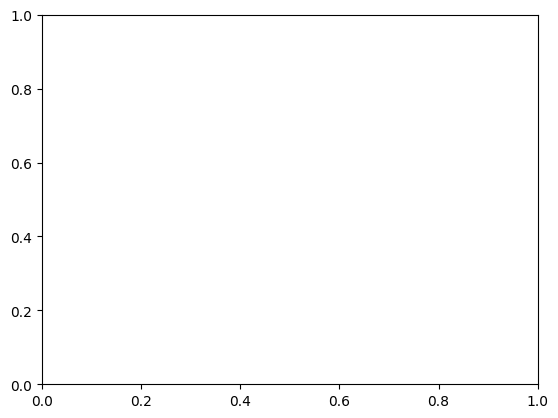

<Figure size 1200x600 with 0 Axes>

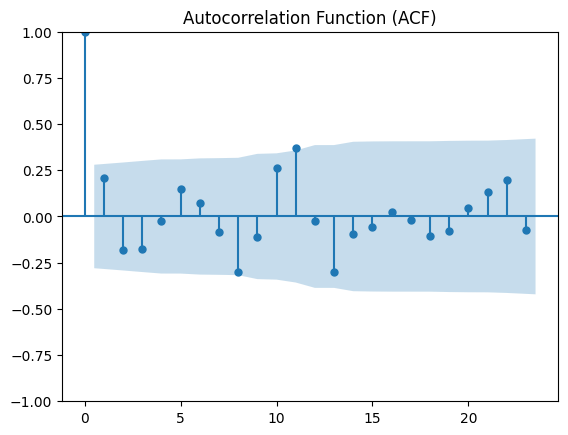

<Figure size 1200x600 with 0 Axes>

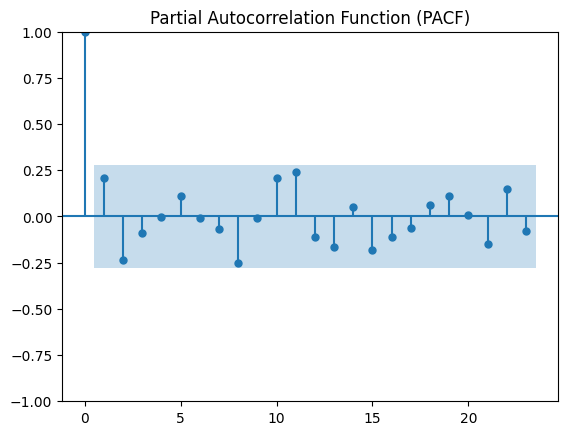


Fitting ARIMA model with order (4, 0, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   49
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -383.602
Date:                Wed, 09 Apr 2025   AIC                            787.205
Time:                        16:26:31   BIC                            806.123
Sample:                             0   HQIC                           794.382
                                 - 49                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1402.8502     59.011     23.772      0.000    1287.190    1518.511
ar.L1          0.6374      0.407      1.567      0.117      -0.160       1.4

<Figure size 1200x600 with 0 Axes>

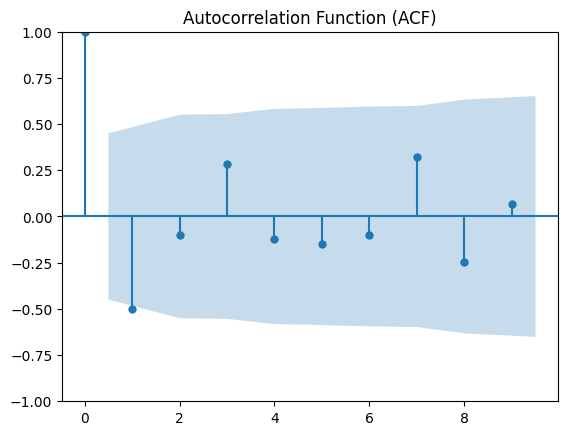

<Figure size 1200x600 with 0 Axes>

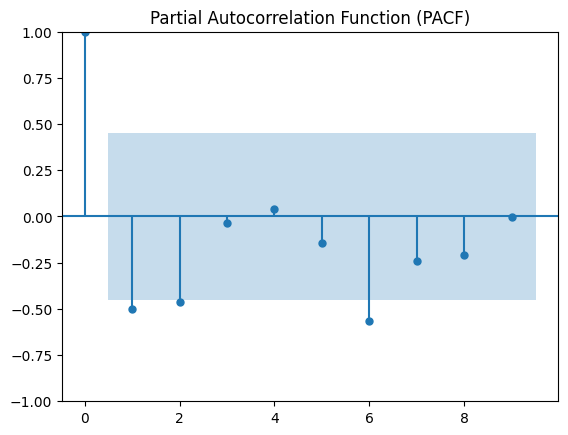


Fitting ARIMA model with order (3, 2, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   21
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -134.443
Date:                Wed, 09 Apr 2025   AIC                            278.887
Time:                        16:26:33   BIC                            283.609
Sample:                             0   HQIC                           279.686
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0263      0.276     -0.095      0.924      -0.568       0.515
ar.L2         -0.0017      0.38

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ક્લંજી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_0e59e7efcba2b8d4f15c49aea2a2949d.pkl
રાયડો size:  43
False
Checking stationarity for the raw price data of રાયડો:

ADF Test Results:
ADF Statistic: -3.5934
p-value: 0.0059
Critical Value 1%: -3.6010
Critical Value 5%: -2.9351
Critical Value 10%: -2.6060
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -3.5934
p-value: 0.0059
Critical Value 1%: -3.6010
Critical Value 5%: -2.9351
Critical Value 10%: -2.6060
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 2 at lags [ 4 12]
Significant spikes in PACF (p): 4 at lags [ 4 12 13 16]


<Figure size 1200x600 with 0 Axes>

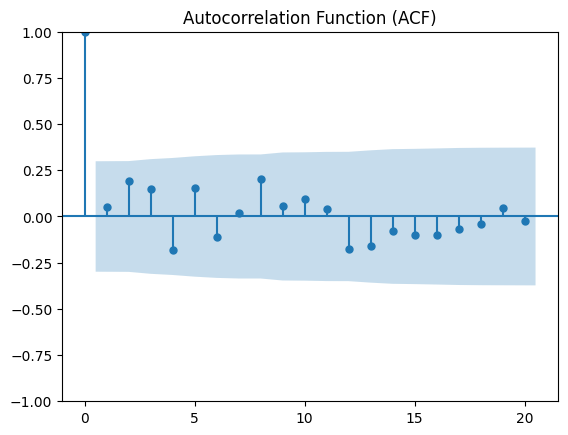

<Figure size 1200x600 with 0 Axes>

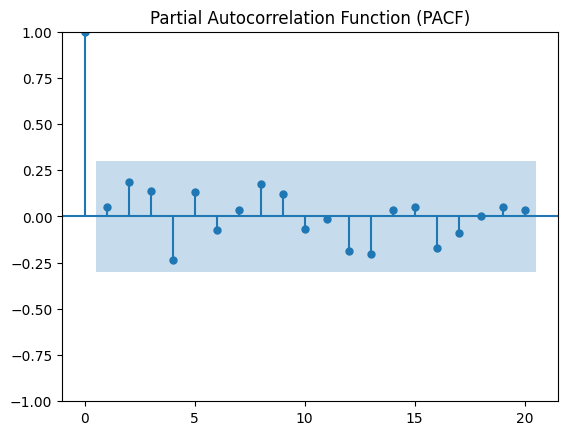


Fitting ARIMA model with order (4, 0, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   43
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -265.308
Date:                Wed, 09 Apr 2025   AIC                            546.617
Time:                        16:26:36   BIC                            560.706
Sample:                             0   HQIC                           551.812
                                 - 43                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        966.5018     40.328     23.966      0.000     887.461    1045.542
ar.L1         -0.8314      0.67

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for રાયડો uploaded to Spaces at ml_models/commodities_saved_models/arima_model_da7c8e19318dc530ec95d09294d2d0fb.pkl
અજમાં size:  16
False
Checking stationarity for the raw price data of અજમાં:

ADF Test Results:
ADF Statistic: -2.8467
p-value: 0.0519
Critical Value 1%: -4.4731
Critical Value 5%: -3.2899
Critical Value 10%: -2.7724
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -6.3095
p-value: 0.0000
Critical Value 1%: -4.0120
Critical Value 5%: -3.1042
Critical Value 10%: -2.6910
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -6.3095
p-value: 0.0000
Critical Value 1%: -4.0120
Critical Value 5%: -3.1042
Critical Value 10%: -2.6910
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [1]
Significant spikes in PACF (p): 5 at lags [1 2 4 5 6]


<Figure size 1200x600 with 0 Axes>

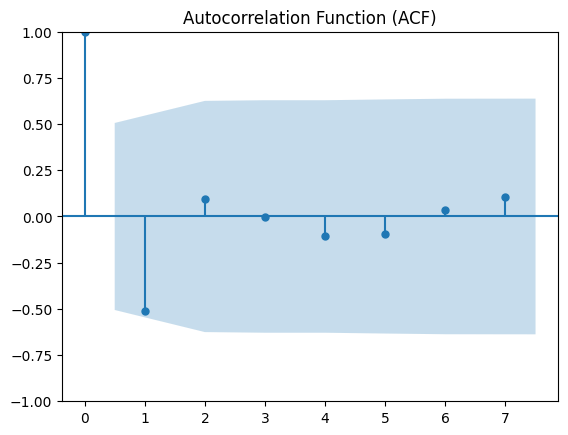

<Figure size 1200x600 with 0 Axes>

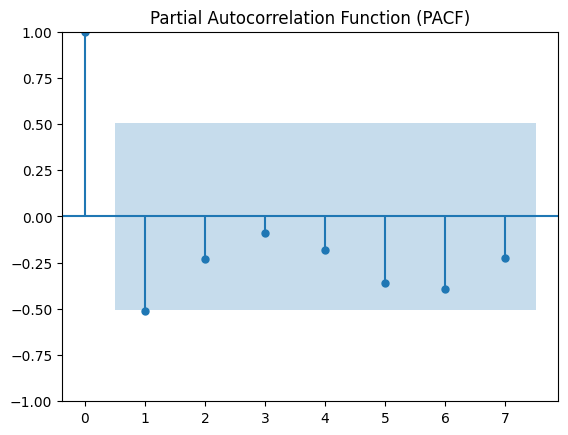


Fitting ARIMA model with order (5, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   16
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -114.175
Date:                Wed, 09 Apr 2025   AIC                            242.349
Time:                        16:26:39   BIC                            247.306
Sample:                             0   HQIC                           242.297
                                 - 16                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4247      0.237     -1.792      0.073      -0.889       0.040
ar.L2          0.0137      0.27

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for અજમાં uploaded to Spaces at ml_models/commodities_saved_models/arima_model_3e157308dc65450922103fc2ec9cb159.pkl
કળથી size:  23
False
Checking stationarity for the raw price data of કળથી:

ADF Test Results:
ADF Statistic: -1.1497
p-value: 0.6949
Critical Value 1%: -4.0689
Critical Value 5%: -3.1271
Critical Value 10%: -2.7017
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -5.0244
p-value: 0.0000
Critical Value 1%: -4.1378
Critical Value 5%: -3.1550
Critical Value 10%: -2.7145
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -5.0244
p-value: 0.0000
Critical Value 1%: -4.1378
Critical Value 5%: -3.1550
Critical Value 10%: -2.7145
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [1]
Significant spikes in PACF (p): 6 at lags [1 2 5 6 7 8]


<Figure size 1200x600 with 0 Axes>

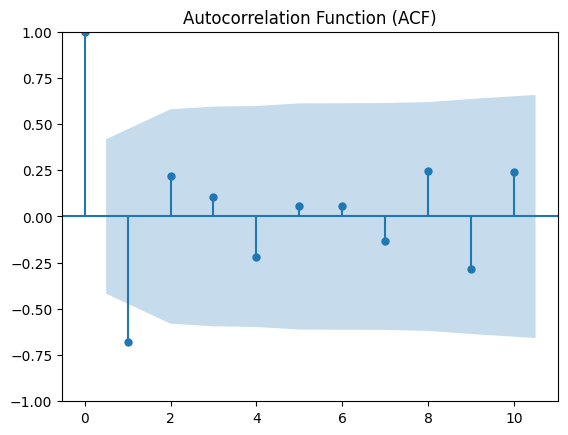

<Figure size 1200x600 with 0 Axes>

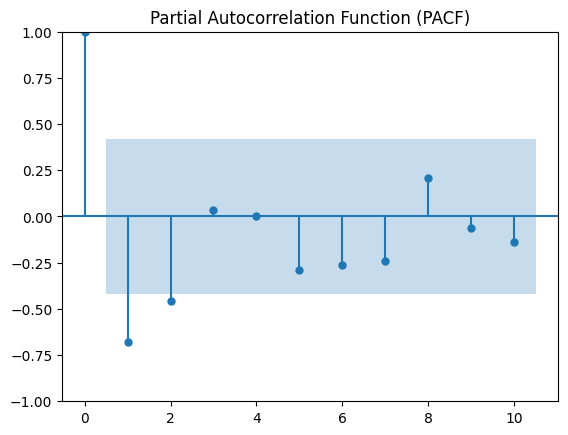


Fitting ARIMA model with order (1, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   23
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -145.825
Date:                Wed, 09 Apr 2025   AIC                            297.649
Time:                        16:26:42   BIC                            300.923
Sample:                             0   HQIC                           298.421
                                 - 23                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3148      0.453     -0.695      0.487      -1.203       0.573
ma.L1         -0.8623      0.26

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for કળથી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_99525a64369d30a26633ab7f717467df.pkl
મરચા સૂકા પટ્ટો size:  24
False
Checking stationarity for the raw price data of મરચા સૂકા પટ્ટો:

ADF Test Results:
ADF Statistic: -1.9348
p-value: 0.3159
Critical Value 1%: -3.7529
Critical Value 5%: -2.9985
Critical Value 10%: -2.6390
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -1.0626
p-value: 0.7297
Critical Value 1%: -3.8591
Critical Value 5%: -3.0420
Critical Value 10%: -2.6609
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -10.8713
p-value: 0.0000
Critical Value 1%: -4.1378
Critical Value 5%: -3.1550
Critical Value 10%: -2.7145
The series is stationary (no further differencing needed).
Data is stationary with d=2.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -10.8713
p-value: 0.0000
Critical Value 1%: -4.1378
Critical Value 5%: -3.15

<Figure size 1200x600 with 0 Axes>

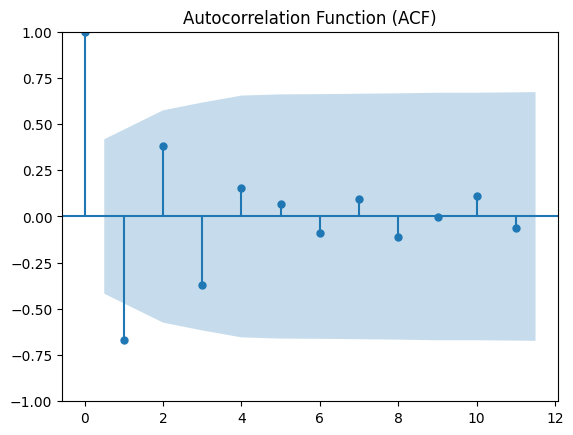

<Figure size 1200x600 with 0 Axes>

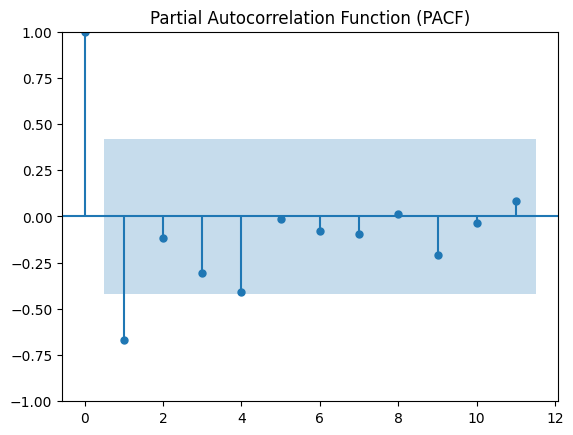


Fitting ARIMA model with order (2, 2, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   24
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -180.293
Date:                Wed, 09 Apr 2025   AIC                            370.586
Time:                        16:26:44   BIC                            376.041
Sample:                             0   HQIC                           371.871
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5218      1.402     -0.372      0.710      -3.270       2.227
ar.L2          0.1215      0.633      0.192      0.848      -1.119       1.3

<Figure size 1200x600 with 0 Axes>

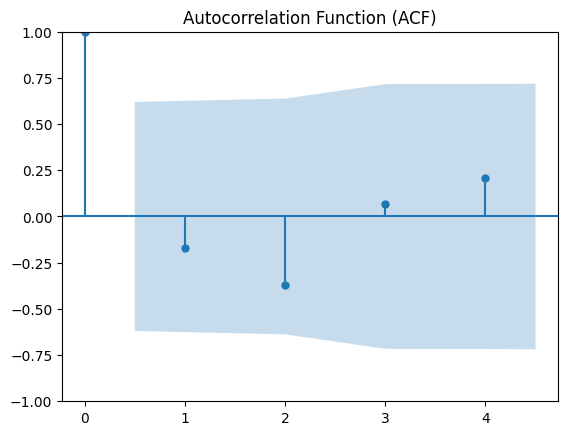

<Figure size 1200x600 with 0 Axes>

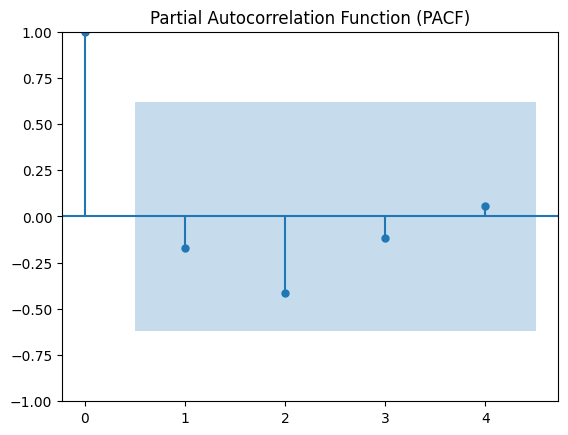


Fitting ARIMA model with order (1, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   10
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -57.259
Date:                Wed, 09 Apr 2025   AIC                            122.518
Time:                        16:26:47   BIC                            123.728
Sample:                             0   HQIC                           121.190
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1214.0903     30.728     39.511      0.000    1153.865    1274.316
ar.L1          0.3975      0.589      0.675      0.500      -0.757       1.5

<Figure size 1200x600 with 0 Axes>

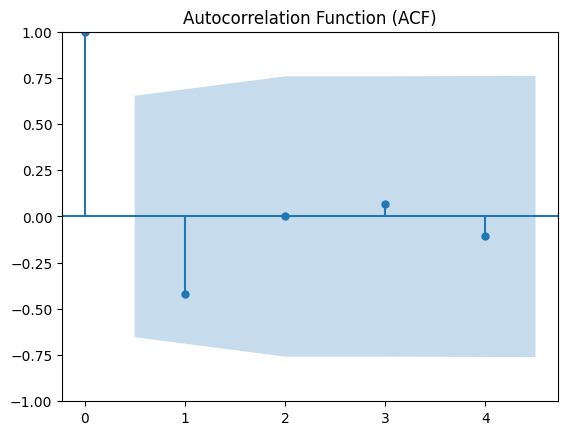

<Figure size 1200x600 with 0 Axes>

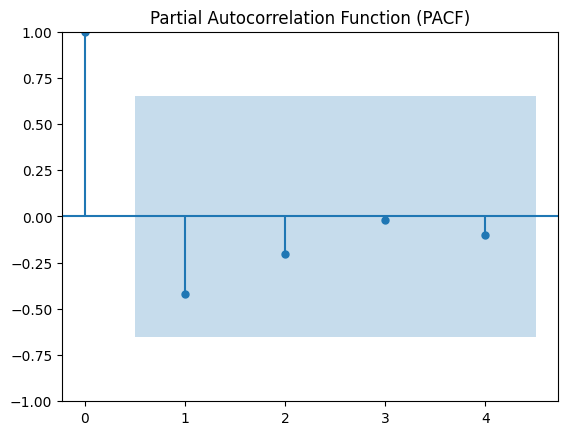


Fitting ARIMA model with order (1, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -63.333
Date:                Wed, 09 Apr 2025   AIC                            132.665
Time:                        16:26:49   BIC                            133.257
Sample:                             0   HQIC                           131.388
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7036      0.463     -1.519      0.129      -1.611       0.204
ma.L1          0.0793      1.00

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for તલ લાલ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_c31181ab0610a68a7920f6ed42dca1ec.pkl
નવા ધાણા size:  24
True
Checking stationarity for the raw price data of નવા ધાણા:

ADF Test Results:
ADF Statistic: -1.8306
p-value: 0.3654
Critical Value 1%: -3.9240
Critical Value 5%: -3.0685
Critical Value 10%: -2.6739
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: 4.0626
p-value: 1.0000
Critical Value 1%: -4.0689
Critical Value 5%: -3.1271
Critical Value 10%: -2.7017
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: 0.4997
p-value: 0.9849
Critical Value 1%: -4.1378
Critical Value 5%: -3.1550
Critical Value 10%: -2.7145
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -5.1947
p-value: 0.0000
Critical Value 1%: -4.1378
Critical Value 5%: -3.1550
Critical Value 10%: -2.7145
The series is stationary (no further differencing needed).
Data is

<Figure size 1200x600 with 0 Axes>

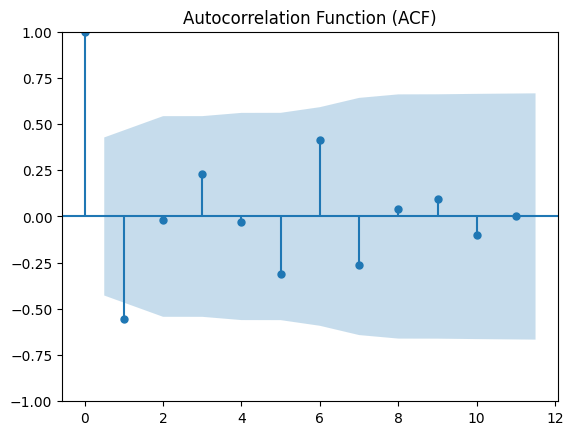

Can't plot the acf/pacf plots for નવા ધાણા due to Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 11 must be < 10.

Fitting ARIMA model with order (3, 3, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   24
Model:                 ARIMA(3, 3, 2)   Log Likelihood                -163.805
Date:                Wed, 09 Apr 2025   AIC                            339.609
Time:                        16:26:51   BIC                            345.877
Sample:                             0   HQIC                           340.970
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0284    235.910     -0.004      0.997    -463.403     461.347
ar.L2         -0.0507      6.632     -0.008      0.994     -13.050      12.948
ar.L3         -0.0222      5.195     -0.004      0.9

<Figure size 1200x600 with 0 Axes>

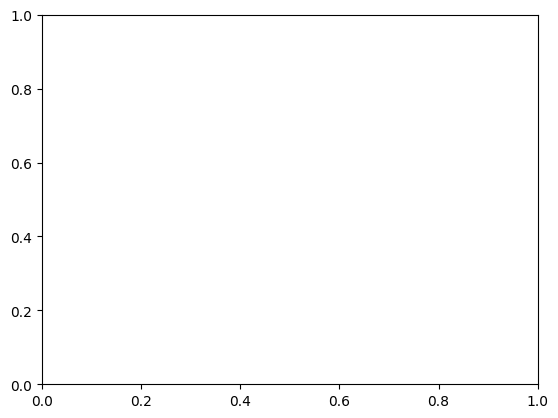

<Figure size 1200x600 with 0 Axes>

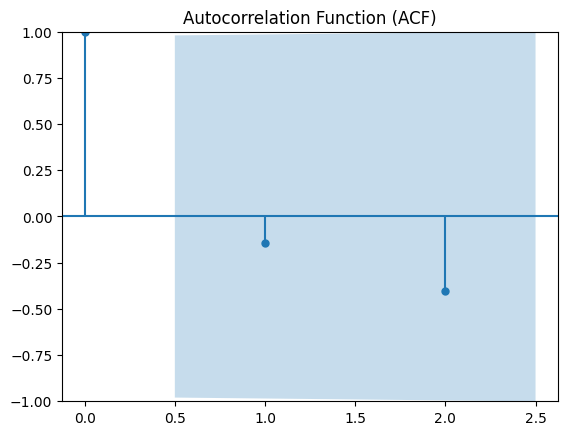

<Figure size 1200x600 with 0 Axes>

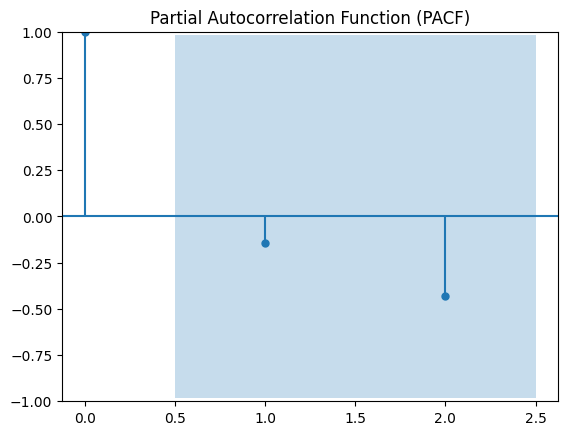


Fitting ARIMA model with order (0, 3, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    7
Model:                 ARIMA(0, 3, 0)   Log Likelihood                 -33.501
Date:                Wed, 09 Apr 2025   AIC                             69.003
Time:                        16:26:54   BIC                             68.389
Sample:                             0   HQIC                            67.656
                                  - 7                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.099e+06   8.95e+05      1.228      0.219   -6.55e+05    2.85e+06
Ljung-Box (L1) (Q):            

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for રજકાનું બી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_7d8513c1ad648bbae8e3d458f23ad8da.pkl
નવી ધાણી size:  24
False
Checking stationarity for the raw price data of નવી ધાણી:

ADF Test Results:
ADF Statistic: -4.5731
p-value: 0.0001
Critical Value 1%: -3.7697
Critical Value 5%: -3.0054
Critical Value 10%: -2.6425
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.5731
p-value: 0.0001
Critical Value 1%: -3.7697
Critical Value 5%: -3.0054
Critical Value 10%: -2.6425
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 2 at lags [2 9]
Significant spikes in PACF (p): 4 at lags [ 2  6  8 10]


<Figure size 1200x600 with 0 Axes>

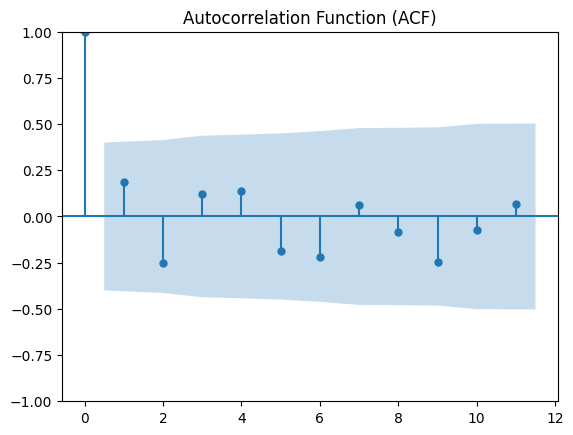

<Figure size 1200x600 with 0 Axes>

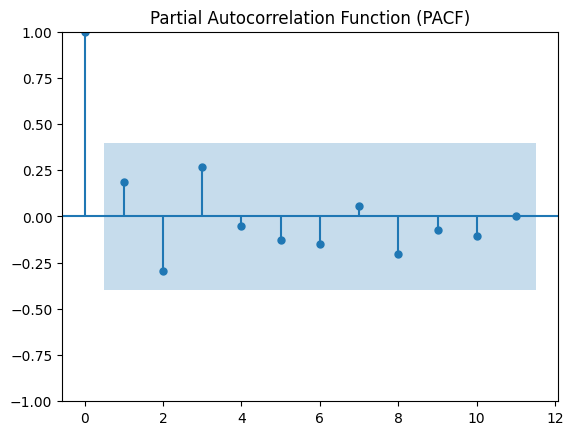


Fitting ARIMA model with order (4, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   24
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -174.034
Date:                Wed, 09 Apr 2025   AIC                            364.069
Time:                        16:26:56   BIC                            373.493
Sample:                             0   HQIC                           366.569
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2290.9421    117.044     19.573      0.000    2061.540    2520.344
ar.L1          0.7153      0.299      2.391      0.017       0.129       1.3

<Figure size 1200x600 with 0 Axes>

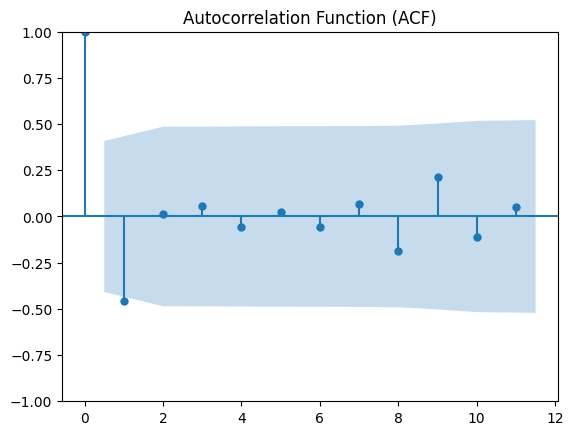

<Figure size 1200x600 with 0 Axes>

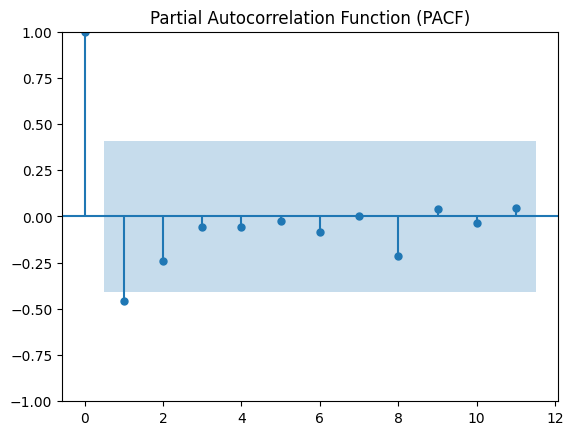


Fitting ARIMA model with order (3, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   24
Model:                 ARIMA(3, 1, 1)   Log Likelihood                   0.000
Date:                Wed, 09 Apr 2025   AIC                             10.000
Time:                        16:26:58   BIC                             15.677
Sample:                             0   HQIC                            11.428
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000   6.28e-07  -1.59e+06      0.000      -1.000      -1.000
ar.L2          1.0000        na

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for નવું લસણ uploaded to Spaces at ml_models/commodities_saved_models/arima_model_fd8740eeef51975fce673af58100e1dc.pkl
નવું જીરૂ size:  17
True
Checking stationarity for the raw price data of નવું જીરૂ:
Stationarity cannot be applicable for નવું જીરૂ
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 0 at lags []


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


<Figure size 1200x600 with 0 Axes>

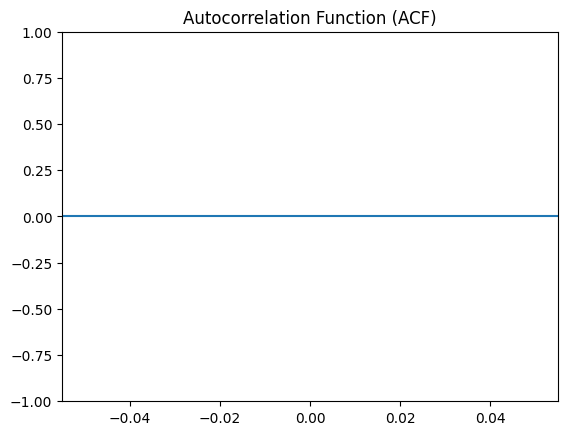

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


<Figure size 1200x600 with 0 Axes>

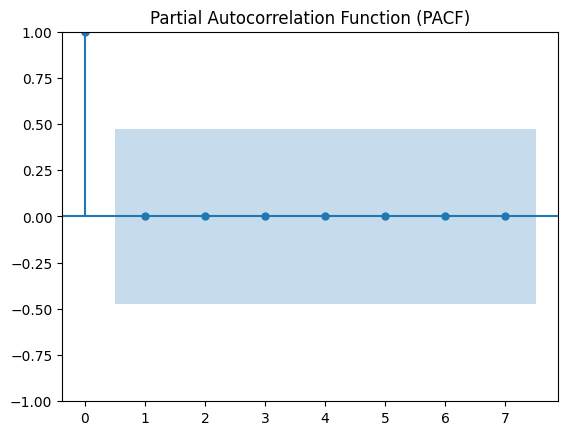

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)



Fitting ARIMA model with order (0, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   17
Model:                          ARIMA   Log Likelihood                -165.003
Date:                Wed, 09 Apr 2025   AIC                            334.005
Time:                        16:27:01   BIC                            335.672
Sample:                             0   HQIC                           334.171
                                 - 17                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5129.2353    1.8e+04      0.284      0.776   -3.02e+04    4.05e+04
sigma2      1.574e+07   3.82e+0

<Figure size 1200x600 with 0 Axes>

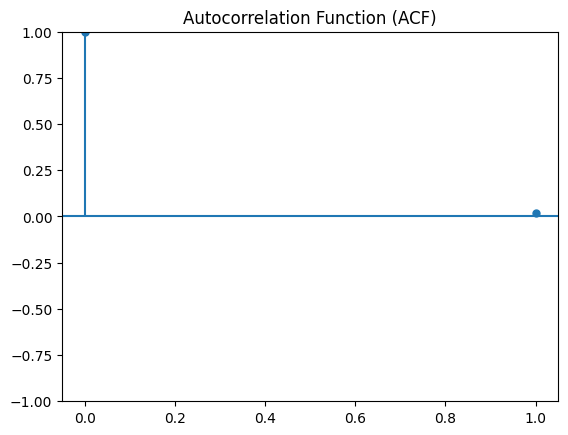

<Figure size 1200x600 with 0 Axes>

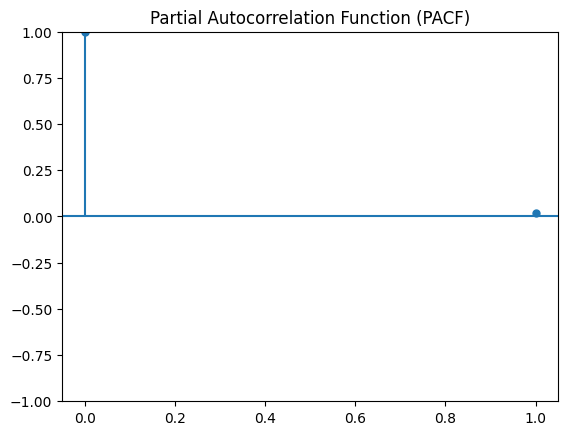


Fitting ARIMA model with order (0, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    5
Model:                          ARIMA   Log Likelihood                 -36.509
Date:                Wed, 09 Apr 2025   AIC                             77.017
Time:                        16:27:03   BIC                             76.236
Sample:                             0   HQIC                            74.921
                                  - 5                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1248.0000    401.320      3.110      0.002     461.427    2034.573
sigma2      1.283e+05   2.04e+0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for વાલ પાપડી uploaded to Spaces at ml_models/commodities_saved_models/arima_model_abb4268fbaab1f48417b77896ce2d084.pkl
કારીજીરી size:  3
નવા ચણા size:  1
ઘઉં નવા size:  1
મરચા સૂકા ઘોલર size:  4
False
Checking stationarity for the raw price data of મરચા સૂકા ઘોલર:

ADF Test Results:
ADF Statistic: -1.6725
p-value: 0.4453
Critical Value 1%: -10.4172
Critical Value 5%: -5.7784
Critical Value 10%: -3.3917
The series is not stationary (differencing is required).
Data is stationary with d=1.

Checking stationarity for the differenced data:
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 0 at lags []


<Figure size 1200x600 with 0 Axes>

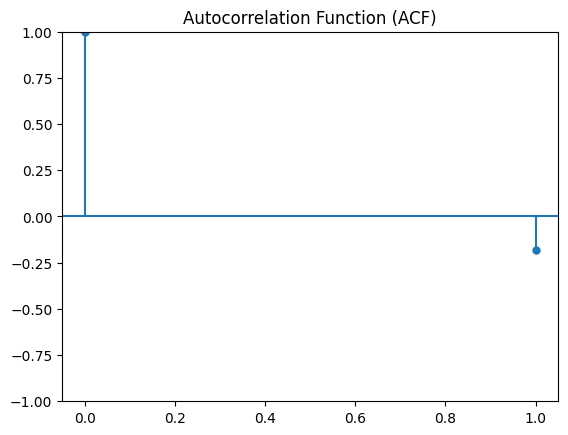

<Figure size 1200x600 with 0 Axes>

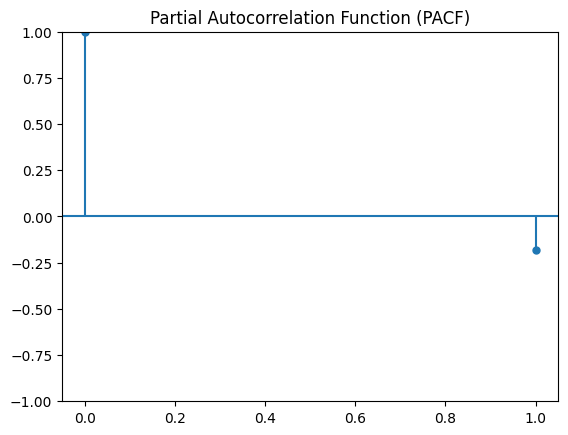


Fitting ARIMA model with order (0, 1, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    4
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -26.664
Date:                Wed, 09 Apr 2025   AIC                             55.329
Time:                        16:27:04   BIC                             54.428
Sample:                             0   HQIC                            53.517
                                  - 4                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.015e+06   6.52e+06      0.462      0.644   -9.76e+06    1.58e+07
Ljung-Box (L1) (Q):            

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for મરચા સૂકા ઘોલર uploaded to Spaces at ml_models/commodities_saved_models/arima_model_8fcdf6a66b43ebe08ac56b000190e32f.pkl


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from dateutil import rrule
from datetime import date
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox, skew
from matplotlib import font_manager as fm
import os
import joblib
import hashlib
import csv
import boto3
import io
from dotenv import load_dotenv
load_dotenv()


###------------------------------------------------------------------------------------------------------------------------------
# Setup your DigitalOcean Spaces client
def get_spaces_client():
    return boto3.client(
        's3',
        region_name=os.getenv("SPACES_REGION"),
        endpoint_url=os.getenv("SPACES_ENDPOINT_URL"),
        aws_access_key_id=os.getenv("SPACES_ACCESS_KEY"),
        aws_secret_access_key=os.getenv("SPACES_SECRET_KEY")
    )

def dump_model_to_spaces(model, product, category):
    try:
        # Prepare filename
        hashed_name = safe_filename(product)
        filename = f"arima_model_{hashed_name}.pkl"
        key = f"ml_models/{category}/{filename}"  
        bucket = os.getenv("SPACES_BUCKET_NAME")
        print(f"Uploading to bucket: {bucket} with key: {key}")

        # Serialize model to bytes
        bytes_buffer = io.BytesIO()
        joblib.dump(model, bytes_buffer)
        bytes_buffer.seek(0)

        # Upload to Spaces
        client = get_spaces_client()
        client.put_object(Bucket=os.getenv("SPACES_BUCKET_NAME"), Key=key, Body=bytes_buffer)

        print(f"Model for {product} uploaded to Spaces at {key}")
    except Exception as e:
        print(f"Error uploading model for {product} to Spaces: {e}")
        

def filterData(existing_data):
    data = existing_data
    
    # Get current date and calculate the cutoff date (4 months ago)
    current_date = datetime.today()
    cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
    cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

    # today_date = datetime.now().strftime("%d/%m/%Y")

    # Filter data to keep only the last 4 months
    filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]
    print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")
    
    return filtered_data


def append_csv_to_spaces(new_df: pd.DataFrame, filename: str):
    client = get_spaces_client()
    key = f"data/commodities/{filename}"

    try:
        # Step 1: Download existing file if it exists
        existing = client.get_object(Bucket=os.getenv("SPACES_BUCKET_NAME"), Key=key)
        existing_data = pd.read_csv(existing['Body'])
        print("📥 Existing CSV loaded from Spaces.")
        
        if(filename == "commodities_price_data.csv"):
            existing_data = filterData(existing_data)
            

        # Step 2: Append new data
        combined_df = pd.concat([existing_data, new_df], ignore_index=True)

    except client.exceptions.NoSuchKey:
        print("ℹ️ No existing file found. Creating a new one.")
        combined_df = new_df

    # Step 3: Upload updated CSV
    csv_buffer = io.StringIO()
    combined_df.to_csv(csv_buffer, index=False)
    csv_buffer.seek(0)

    client.put_object(Bucket=os.getenv("SPACES_BUCKET_NAME"), Key=key, Body=csv_buffer.getvalue())

    print(f"✅ CSV saved to Spaces at {key}")



products_with_boxcox = []
### removes data older than 4 months-----------------------------------------------------------------------------------------------
base_dir = Path(os.getenv("BASE_DIRECTORY"))
file_path = base_dir / "data/commodities/commodities_price_data.csv"


# csv_file = "commodities_price_data.csv"  # Update with your file path
save_dir = base_dir / "ml_models/commodities_saved_models"
filename = base_dir / "ml_models/commodities_saved_models/vegetables_parameters.csv"
allYearsFilename = base_dir / "data/commodities/commodities_price_data-all_years.csv"
os.makedirs(save_dir, exist_ok=True)
data = pd.read_csv(file_path, encoding='utf-8', parse_dates=['Date'], date_format='%d/%m/%Y')
print(data.head())
products = data['Item Name'].unique()
print(products)

# Get current date and calculate the cutoff date (4 months ago)
current_date = datetime.today()
cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

today_date = datetime.now().strftime("%d/%m/%Y")

# Filter data to keep only the last 4 months
filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]

# Save the cleaned data back to CSV
filtered_data.to_csv(file_path, encoding='utf-8', index=False)

print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")

logs = []
###------------------------------------------------------------------------------------------------------------------------------



###Saving updated ARIMA models---------------------------------------------------------------------------------------------------

# Step 1: Stationarity Check
def check_stationarity(series, size):
    if len(series) == size:
        return True
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("The series is stationary (no further differencing needed).")
        return True
    else:
        print("The series is not stationary (differencing is required).")
        return False

# Function to count significant lags
def count_significant_spikes(values, confint):
    # The significant lags are those outside the confidence interval
    significant_lags = np.where(np.abs(values) > confint[:, 1])[0]
    return len(significant_lags), significant_lags

# Function to generate a safe file name
def safe_filename(product_name):
    return hashlib.md5(product_name.encode('utf-8')).hexdigest()





###updating the csv with current data---------------------------------------------------------------------------------------------

def write_to_csv(data, filename):
    # Define the field names for the CSV file
    # fieldnames = ['Serial Number', 'Date', 'Item Name', 'Low Price', 'Average Price', 'High Price']
    
    # Write data to CSV file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        # writer.writerow(fieldnames)
        
        # Write data rows
        for _, row_data in enumerate(data):
            date = row_data[0]
            item_name = row_data[2]
            low_price = row_data[3]
            avg_price = row_data[5]
            high_price = row_data[4]
            writer.writerow([date, item_name, low_price, avg_price, high_price])
            
            
def getData(driver, csv_file_name, webpage_path, date_path, submit_button_path, table_path):
    
    # add_field_names_price(csv_file_name)
    
    #iterate over all the dates    
    try:
        # Open the webpage
        driver.get(webpage_path)
            
        # Find the date input element
        date_input = driver.find_element(By.XPATH, date_path)

        # Clear any existing text in the date input field
        date_input.clear()
          
        # Enter the desired date
        date_input.send_keys(current_date.strftime('%d-%m-%Y'))  # Example date, replace with your desired date

        # Find and click the button to get data for the specified date
        submit_button = driver.find_element(By.XPATH, submit_button_path)
        submit_button.click()
         
        time.sleep(3) #to load data

        #Extract the table data
        table = driver.find_element(By.XPATH, table_path)
        # print(table)
        data = []

        # Iterate over each row in the table
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find all cells (td) in the row
            cells = row.find_elements(By.TAG_NAME, "td")
                
            # Ensure that there are cells in the row
            if cells:
                # Extract text from each cell and append to the data list
                row_data = [current_date.strftime('%d-%m-%Y')] + [cell.text.strip() for cell in cells]
                data.append(row_data)
        
        
        columns = ["Date", "Some Extra Column", "Item Name", "Low Price", "Average Price", "High Price"]
        new_df = pd.DataFrame(data, columns=columns)
        print("Before dropping the column:")
        print(new_df.head())
        

        # Drop the column at index 1 (which corresponds to "Item Name")
        new_df.drop(new_df.columns[1], axis=1, inplace=True)
        
        print("\nAfter dropping the column:")
        print(new_df.head())
        
        new_df['Average Price'], new_df['High Price'] = new_df['High Price'], new_df['Average Price']

        # Print the new DataFrame to verify
        print("\nAfter rearranging the column:")
        print(new_df.head())


        # Print the extracted data for debugging
        # for row in data:
        #     print(row)
        write_to_csv(data, csv_file_name)
        append_csv_to_spaces(new_df, "commodities_price_data.csv")
        write_to_csv(data, allYearsFilename)
        append_csv_to_spaces(new_df, "commodities_price_data-all_years.csv")
        time.sleep(2)
        # return data
            
    except Exception as e:
        print(e)
        pass


def main():
    # Initialize Chrome WebDriver
    driver = webdriver.Chrome()

    # commodities_data_table = 
    getData(driver, file_path, os.getenv("COMMODITIES_WEBPAGE_PATH"), 
                                             os.getenv("COMMODITIES_DATE_PATH"),
                                             os.getenv("COMMODITIES_SUBMIT_BUTTON_PATH"),
                                             os.getenv("COMMODITIES_TABLE_PATH"))
    
    time.sleep(5)
    
    # Close the WebDriver
    driver.quit()
    
    
    
    ###Updating models------------------------------------------------------------------------------------------------------------
    
    for product in products:
    
        product_name = product 
        product_data = data[data['Item Name'] == product_name]
        size_product_data = product_data.shape[0]
        print(product_name, "size: ", size_product_data)
        
        if((size_product_data//2)-1 <= 0):
            continue
        
        # Check if any data exists for the selected product
        if product_data.empty:
            print(f"No data found for the product: {product_name}")

        else:
            # Extract the 'Average Price' column for the selected product
            price_data = product_data['Average Price']
            
        variance_ratio = price_data.std() / price_data.mean()
        skewness = skew(price_data)

        if variance_ratio > 0.1 and skewness > 0.5:
            apply_boxcox = True
            products_with_boxcox.append(product_name)
        else:
            apply_boxcox = False
        
        
        print(apply_boxcox)
        # Step 2: Differencing (if necessary)
        print(f"Checking stationarity for the raw price data of {product_name}:")
        d = 0
        price_diff = price_data
        
        try:
            if apply_boxcox:
                price_diff, lam = boxcox(price_diff)
                price_diff = pd.Series(price_diff)
        
            while True:
                if check_stationarity(price_diff, (size_product_data//2)+1):
                    # price_diff = price_data
                    print(f"Data is stationary with d={d}.")
                    break
                else:
                    price_diff = price_diff.diff().dropna()
                    d += 1
        

            print("\nChecking stationarity for the differenced data:")
            check_stationarity(price_diff, (size_product_data//2)+1)
        
        except Exception as e:
            print(f"Stationarity cannot be applicable for {product_name}")
        
        
        # Step 3: Plot ACF and PACF

        acf_values, acf_confint = acf(price_diff, alpha=0.05)
        pacf_values, pacf_confint = pacf(price_diff, alpha=0.05)


        # Count significant spikes for ACF (q)
        q, significant_acf_lags = count_significant_spikes(acf_values, acf_confint)

        # Count significant spikes for PACF (p)
        p, significant_pacf_lags = count_significant_spikes(pacf_values, pacf_confint)

        print(f"Significant spikes in ACF (q): {q} at lags {significant_acf_lags}")
        print(f"Significant spikes in PACF (p): {p} at lags {significant_pacf_lags}")

        # ACF and PACF Plots
        try:
            plt.figure(figsize=(12, 6))
            plot_acf(price_diff, lags=(size_product_data//2)-1, title="Autocorrelation Function (ACF)")
            plt.show()

            plt.figure(figsize=(12, 6))
            plot_pacf(price_diff, lags=(size_product_data//2)-1, title="Partial Autocorrelation Function (PACF)")
            plt.show()
        
        except Exception as e:
            print(f"Can't plot the acf/pacf plots for {product_name} due to {e}")
        
        if p > 5:
            p = min(5, q)
        if q > 5: 
            q = min(5, p)
        if d > 3:
            d = 1

        fit_successful = False

        while not fit_successful and q >= 0:
            try:
                print(f"\nFitting ARIMA model with order ({p}, {d}, {q})...")
                model = ARIMA(price_data, order=(p, d, q))
                model_fit = model.fit()
                fit_successful = True  
                print("ARIMA model fitted successfully!")
                
            except np.linalg.LinAlgError as err:
                print(f"Error encountered: {err}")
                if q > 0: 
                    q -= 1
                    print(f"Reducing q to {q} and trying again...")
                else:
                    print("Unable to fit model after reducing q multiple times. Exiting loop.")
                    break  
        
        
        # Step 5: Analyze Model Summary
        print("\nARIMA Model Summary:")
        print(model_fit.summary())
        
        
        
        try:
            # Assume model_fit is the fitted ARIMA model for this product
            dump_model_to_spaces(model_fit, product, "commodities_saved_models")
        except Exception as e:
            print(f"Error saving model for {product}: {e}")


if __name__ == "__main__":
    main()
